In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.linalg as la
sns.set(style='whitegrid')
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais
np.set_printoptions(precision=2, suppress=True)      # numpy: para todos os números aparecerem com duas casas decimais

In [2]:
# biplot com nomes nas observações
def biplot_names(score,coeff,labels=None,x=15,y=10,eixo_x='CP1',eixo_y='CP2'):
    fig, ax = plt.subplots(figsize=(x,y))
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs * scalex
    yy = ys * scaley
    plt.scatter(xx, yy, s=2, linewidths=6)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.8)
        if labels is None:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, "Var"+str(i+1), color='green', ha='center', va='center')
        else:
            plt.text(coeff[i,0]* 1.1, coeff[i,1] * 1, labels[i], color='g', ha='center', va='center')
    for i, txt in enumerate(resultado.index):
      ax.annotate(txt, (xx[i], yy[i]), color='gray', fontsize=8)

    plt.xlabel(eixo_x)
    plt.ylabel(eixo_y)
    ax.set(xlim=(-1, 1), ylim=(-1, 1))
    plt.grid()
    plt.show()

In [3]:
# função para padronizar os valores das variáveis originais
def scale_sizes(sizes, min_size=1, max_size=2000):
    return ((sizes - np.min(sizes)) / (np.max(sizes) - np.min(sizes))) * (max_size - min_size) + min_size

In [4]:
# função para gerar diagramas de dispersão com bolhas de forma automática
def bubbles(df, pc, x=15, y=10):
  from random import randint
  colors = []
  for i in range(len(df.columns)):    # lista automática de cores
    colors.append('#%06X' % randint(0, 0xFFFFFF))
  for var, cor in zip(df.columns, colors):
    fig, ax = plt.subplots()
    fig.set_size_inches(x, y)
    xs = pc.iloc[:,0]
    ys = pc.iloc[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    xx = xs*scalex
    yy = ys*scaley
    scaled_sizes = scale_sizes(df[var])
    ax.scatter(xx, yy, s=scaled_sizes, linewidths=2, color=cor)
    plt.xlabel('CP1', fontsize=12)
    plt.ylabel('CP2', fontsize=12)
    plt.title(var, fontsize=12)
    for i, txt in enumerate(pc.index):
        ax.annotate(txt, (xx.iloc[i], yy.iloc[i]), fontsize=9)
    plt.hlines(0, xx.min(), xx.max(), color='gray')
    plt.vlines(0, yy.min(), yy.max(), color='gray');

# Dados de poluição do ar

* SO2: teor de SO2 do ar em microgramas por metro cúbico;
* temp: temperatura média anual em graus Fahrenheit;
* manu: número de empresas industriais que empregam 20 ou mais trabalhadores;
* popul: tamanho da população (censo de 1970) em milhares;
* wind: velocidade média anual do vento em milhas por hora;
* precip: precipitação média anual em polegadas;
* predays: número médio de dias com precipitação por ano.

Leitura do conjunto de dados pelo google drive:

Altere o endereço do arquivo ou faça o upload de outra forma


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/Multivariada/dados')
# dados = pd.read_csv('air.csv', index_col='city')

In [6]:
# ou pelo github
dados = pd.read_csv('https://patriciasiqueira.github.io/arquivos/air.csv', index_col='city')

In [7]:
dados.shape

(41, 7)

In [8]:
dados.head(10)

SO2  temp  manu  popul  wind  precip  predays
city                                                      
Albany        46 47.60    44    116  8.80   33.36      135
Albuquerque   11 56.80    46    244  8.90    7.77       58
Atlanta       24 61.50   368    497  9.10   48.34      115
Baltimore     47 55.00   625    905  9.60   41.31      111
Buffalo       11 47.10   391    463 12.40   36.11      166
Charleston    31 55.20    35     71  6.50   40.75      148
Chicago      110 50.60  3344   3369 10.40   34.44      122
Cincinnati    23 54.00   462    453  7.10   39.04      132
Cleveland     65 49.70  1007    751 10.90   34.99      155
Columbus      26 51.50   266    540  8.60   37.01      134

## Análise exploratória

In [9]:
dados.describe()

SO2  temp    manu   popul  wind  precip  predays
count  41.00 41.00   41.00   41.00 41.00   41.00    41.00
mean   30.05 55.76  463.10  608.61  9.44   36.77   113.90
std    23.47  7.23  563.47  579.11  1.43   11.77    26.51
min     8.00 43.50   35.00   71.00  6.00    7.05    36.00
25%    13.00 50.60  181.00  299.00  8.70   30.96   103.00
50%    26.00 54.60  347.00  515.00  9.30   38.74   115.00
75%    35.00 59.30  462.00  717.00 10.60   43.11   128.00
max   110.00 75.50 3344.00 3369.00 12.70   59.80   166.00

In [10]:
dados.corr()

SO2  temp  manu  popul  wind  precip  predays
SO2      1.00 -0.43  0.64   0.49  0.09    0.05     0.37
temp    -0.43  1.00 -0.19  -0.06 -0.35    0.39    -0.43
manu     0.64 -0.19  1.00   0.96  0.24   -0.03     0.13
popul    0.49 -0.06  0.96   1.00  0.21   -0.03     0.04
wind     0.09 -0.35  0.24   0.21  1.00   -0.01     0.16
precip   0.05  0.39 -0.03  -0.03 -0.01    1.00     0.50
predays  0.37 -0.43  0.13   0.04  0.16    0.50     1.00

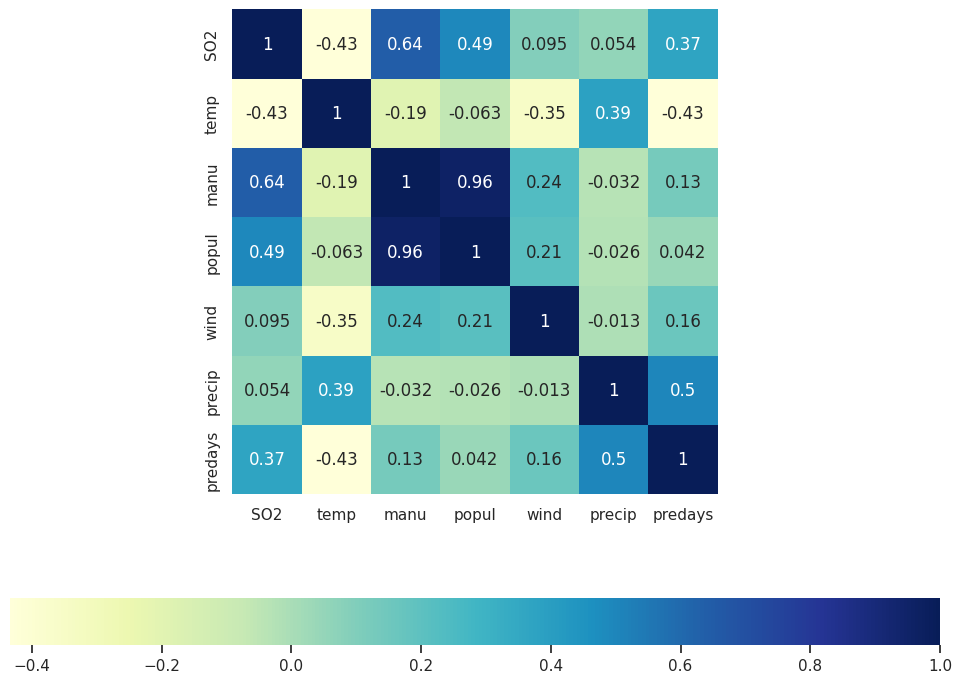

In [11]:
plt.figure(figsize=(12,9))
ax = sns.heatmap(dados.corr(),
                 annot=True,
                 cmap='YlGnBu',
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

Quais as variáveis são mais correlacionadas? E menos?

Mais correlacionadas: manu e popul (+), manu e SO2 (+), precip e predays (+), temp e SO2 (-) e temp e predays (-).

Menos correlacionadas: precip com wind, popul, manu e SO2; popul e temp.

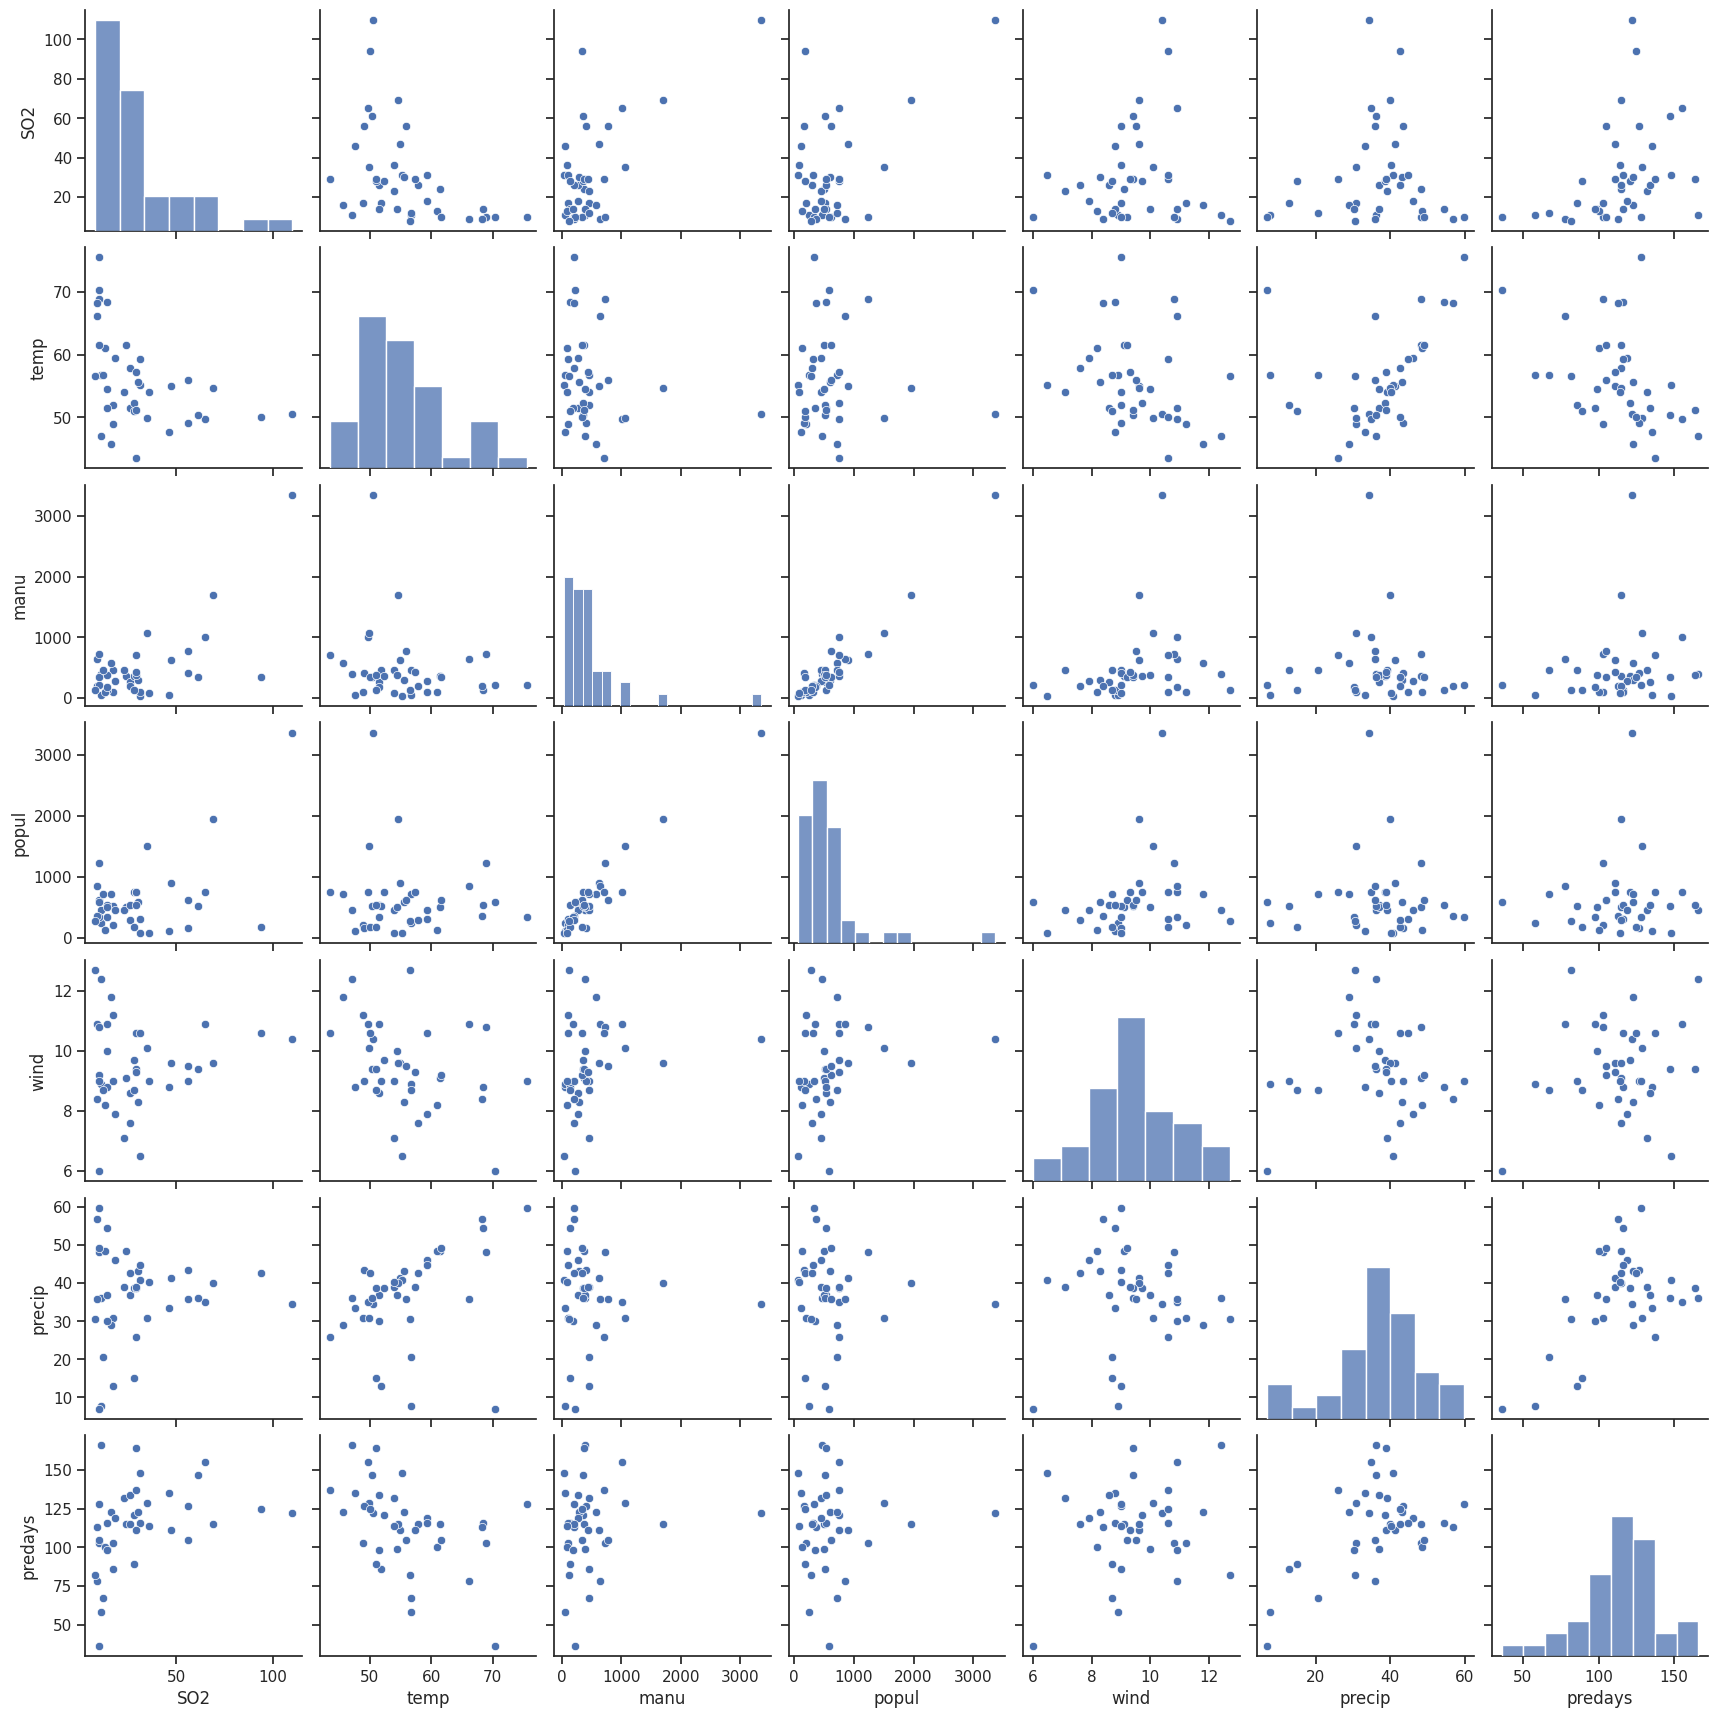

In [12]:
sns.set(style='ticks')
sns.pairplot(dados);

Boxplots:

In [13]:
# dados padronizados
# Y = scale(dados)
# sns.boxplot(data=Y);

Se os dados não forem padronizados, as variáveis com maiores valores dominam o gráfico:

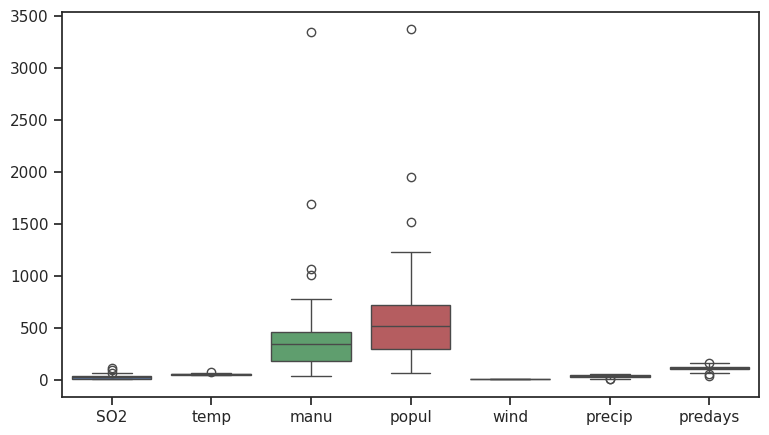

In [14]:
# se não padronizar os dados
# boxplots
plt.figure(figsize=(9,5))
sns.boxplot(data=dados);

Boxplots separados:

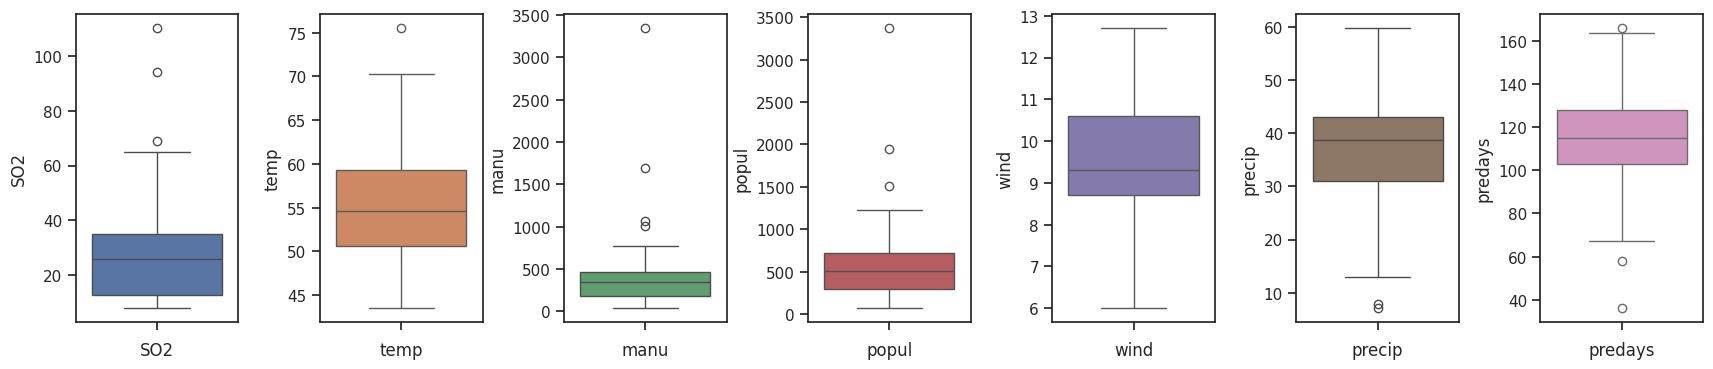

In [15]:
num_columns = len(dados.columns)
num_rows = 1
num_cols = num_columns
# tamanho da figura
fig_width = num_cols * 3   # pode alterar
fig_height = 4             # pode alterar
# criar a figura
fig, ax = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
plt.subplots_adjust(wspace=0.5)  #espaçamento entre subplots
for i, var in enumerate(dados.columns):
    sns.boxplot(data=dados[var], ax=ax[i], color='C{}'.format(i))  # C0, C1, C2 são cores automáticas
    ax[i].set_xlabel(var)
    ax[i].set_xticklabels([])  # remover o eixo x

plt.show()

## Obtenção dos componentes principais a partir da matriz R (usando *scikit-learn*)

In [16]:
# X = dados.iloc[:,1:]  # se quisermos selecionar variáveis
X = dados
# aplicar ACP usando a matriz de correlações
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [17]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.49, -0.32,  0.54,  0.49,  0.25,  0.  ,  0.26],
       [ 0.08, -0.09, -0.23, -0.28,  0.06,  0.63,  0.68],
       [ 0.01,  0.68,  0.27,  0.34, -0.31,  0.49, -0.11],
       [-0.4 ,  0.19,  0.03,  0.11,  0.86,  0.18, -0.11],
       [ 0.73,  0.16, -0.16, -0.35,  0.27,  0.16, -0.44],
       [ 0.18,  0.61, -0.04, -0.09,  0.15, -0.55,  0.5 ],
       [-0.15,  0.02,  0.75, -0.65, -0.02,  0.01, -0.01]])

In [18]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.49 -0.32  0.54  0.49  0.25  0.    0.26]
 [ 0.08 -0.09 -0.23 -0.28  0.06  0.63  0.68]
 [ 0.01  0.68  0.27  0.34 -0.31  0.49 -0.11]]


In [19]:
X.columns

Index(['SO2', 'temp', 'manu', 'popul', 'wind', 'precip', 'predays'], dtype='object')

Então, os três primeiros componentes principais são (os restantes foram omitidos):

\begin{align*}
  Y_1 = & + 0,49Z_1 - 0,32Z_2 + 0,54Z_3 + 0,49Z_4 + 0,25Z_5 + 0,00Z_6 + 0,26Z_7\\
  Y_2 = & + 0,08Z_1 - 0,09Z_2 - 0,23Z_3 - 0,28Z_4 + 0,06Z_5 + 0,63Z_6 + 0,68Z_7\\
  Y_3 = & + 0,01Z_1 + 0,68Z_2 + 0,27Z_3 + 0,34Z_4 - 0,31Z_5 + 0,49Z_6 - 0,11Z_7\\
\end{align*}


ou (para simplificar)


\begin{align*}
  Y_1 = & + 0,49 SO2_p - 0,32 temp_p + 0,54 manu_p + 0,49 popul_p + 0,25 wind_p + 0,00 precip_p + 0,26 predays_p\\
  Y_2 = & + 0,08 SO2_p - 0,09 temp_p - 0,23 manu_p - 0,28 popul_p + 0,06 wind_p + 0,63 precip_p + 0,68 predays_p\\
  Y_3 = & + 0,01 SO2_p + 0,68 temp_p + 0,27 manu_p + 0,34 popul_p - 0,31 wind_p + 0,49 precip_p - 0,11 predays_p\\
\end{align*}

Interpretação:

- Y1: índice global de qualidade de vida - escores altos indicam cidades com maior concentração de S02, maiores, com mais fábricas, mais gente, mais vento, mais dias chuvosos, temp. baixas
- Y2: índice de chuvas - escores altos positivos indicam cidades chuvosas
- Y3: leva em conta chuvas e temperatura - altos valores para cidades quentes e úmidas e baixos para frias e secas

In [20]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([2.8 , 1.55, 1.43, 0.91, 0.36, 0.1 , 0.03])

As variâncias dos três primeiros componentes principais:

\begin{align*}
  V(Y_1) = 2,80\\
  V(Y_2) = 1,55\\
  V(Y_3) = 1,43\\
\end{align*}

In [21]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([38.97, 60.57, 80.5 , 93.24, 98.19, 99.62, 99.98])

$Y_1$ explica 39\% da variação dos dados.

$Y_1$ e $Y_2$ explicam juntos 61\% da variação dos dados.

$Y_1$, $Y_2$ $Y_3$ explicam juntos 81\% da variação dos dados.

In [22]:
# escores dos dois primeiros CPs
# resultado

### Análise gráfica dos componentes

### Gráfico da variância acumulada

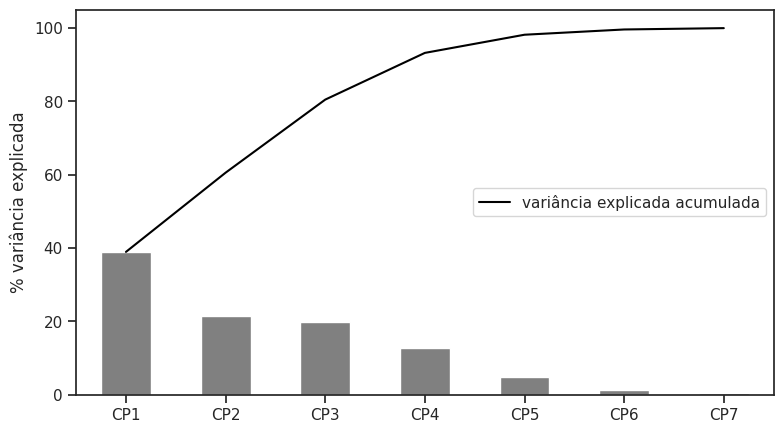

In [23]:
# variâncias acumuladas
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot com %
fig, ax = plt.subplots(figsize=(9,5))
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='center right',)
plt.ylabel('% variância explicada')
plt.xlabel('');

### *Scree plot*

O *Scree plot* é um gráfico com os autovalores de cada componente

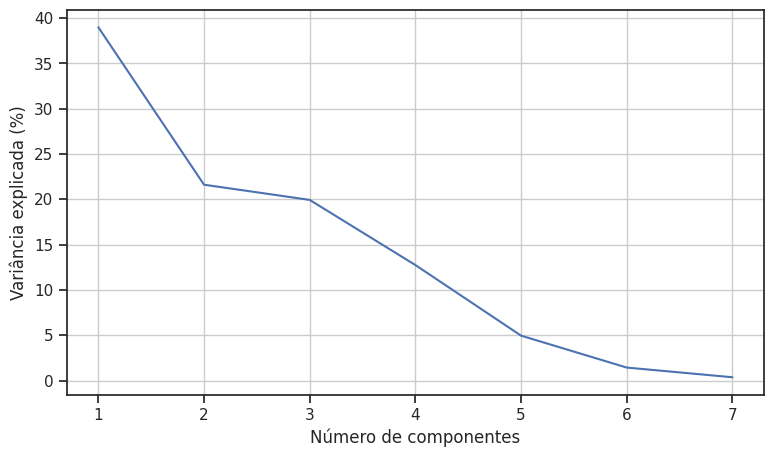

In [24]:
plt.figure(figsize=(9,5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_ * 100)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada (%)')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid()
plt.show()

É possível ver pelo gráfico que o primeiro componente explica quase  $40\%$ da variância dos dados.

### Diagrama de dispersão entre CP1 e CP2

Nesse gráfico vamos visualizar a relação entre os dois primeiros CPs.

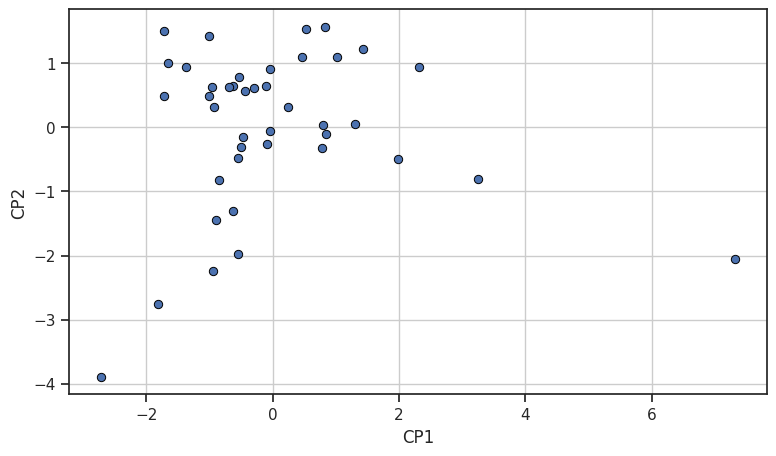

In [25]:
plt.figure(figsize=(9,5))
plt.scatter(resultado_pca[:, 0], resultado_pca[:, 1], edgecolors='black', linewidths=.7);
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.grid();

### Efeito das variáveis em cada componente

O atributo 'components_' nos dá os autovetores que representam a direção de máxima variância dos dados.

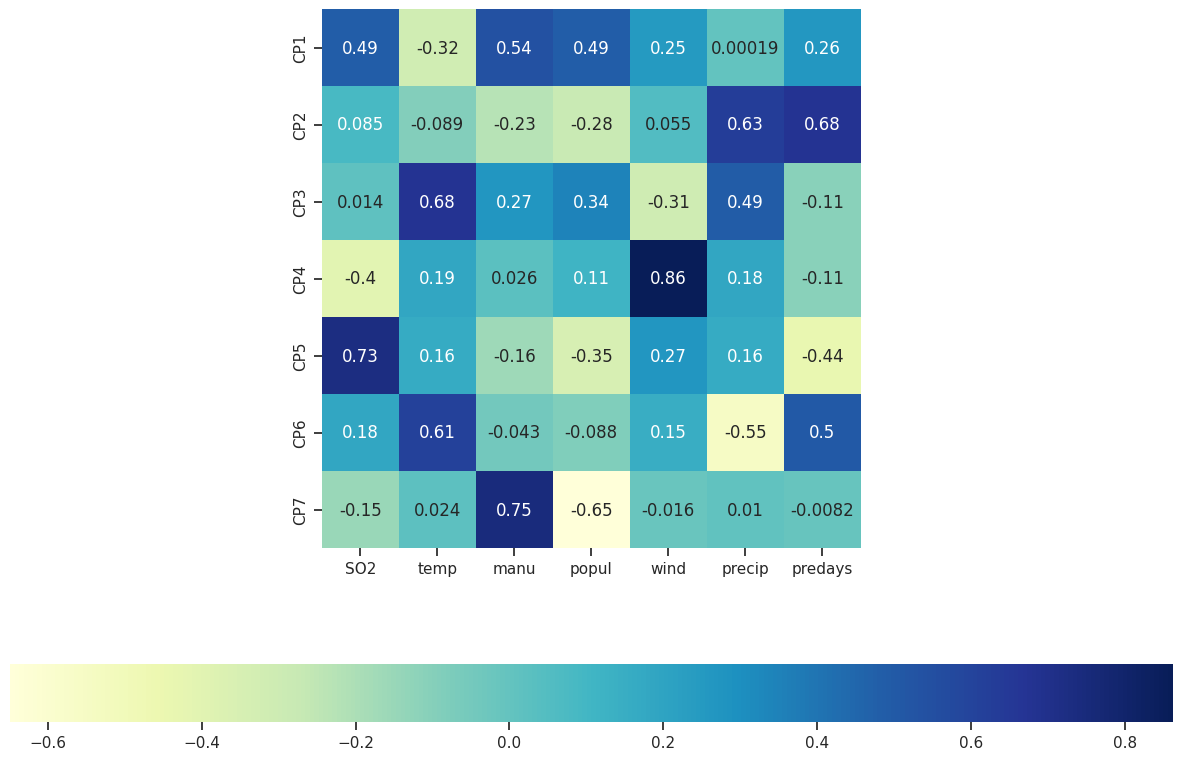

In [26]:
plt.figure(figsize=(15,10))
ax = sns.heatmap(pca.components_,
                 annot=True,
                 cmap='YlGnBu',
                 yticklabels=[ "CP"+str(X) for X in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")


### ACP *Biplot*

Biplot é um gráfico interessante e contém muitas informações úteis.

Ele contém dois gráficos:

1. * Gráfico de dispersão do ACP * que mostra os escores dos dois primeiros componentes
2. * Gráfico de autovetores do ACP * que mostra a intensidade com que cada característica influencia um componente principal.

**PCA Loading Plot:** Todos os vetores começam na origem e seus valores projetados nos componentes explicam quanto peso eles têm naquele componente. Além disso, os ângulos entre vetores individuais informam sobre a correlação entre eles.

Mais sobre o biplot: http://www.nonlinear.com/support/progenesis/comet/faq/v2.0/pca.aspx

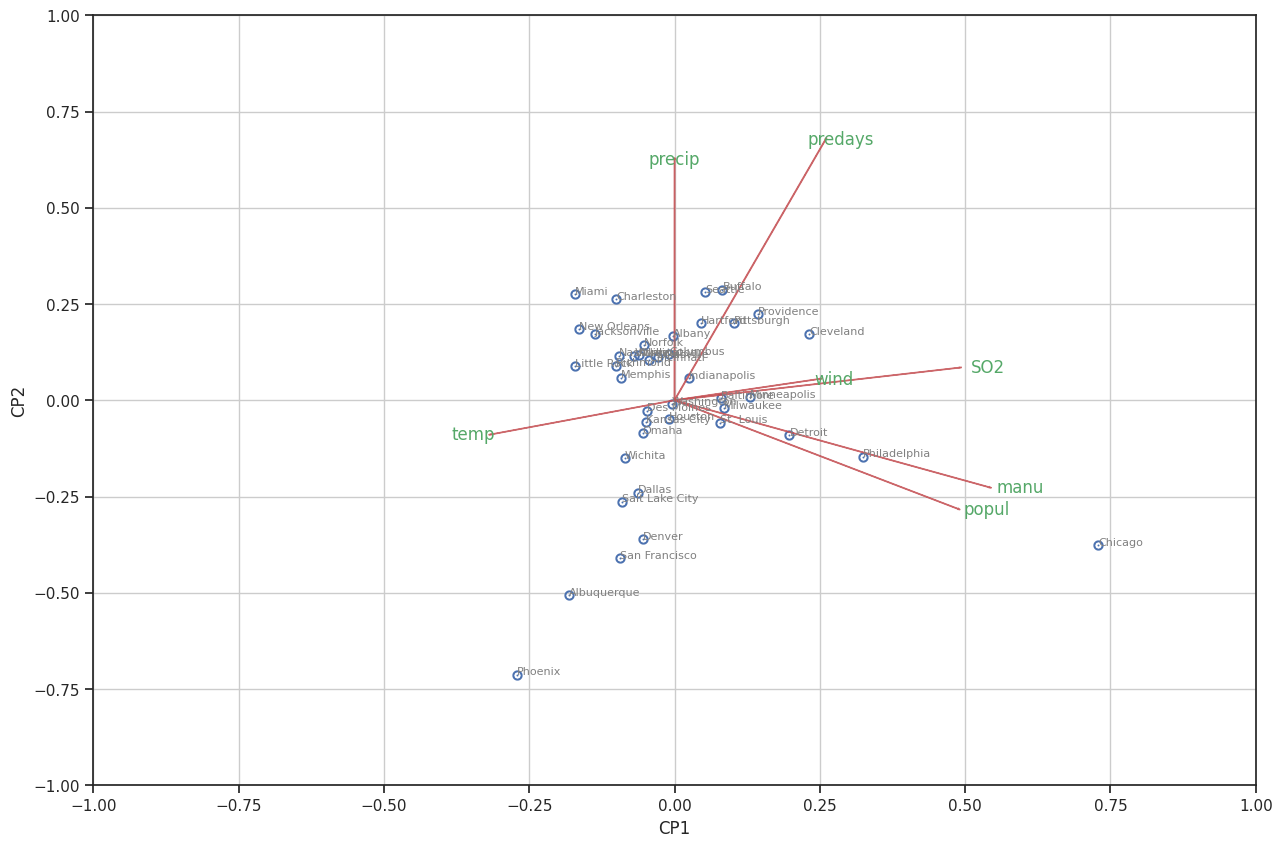

In [27]:
# biplot com nomes nas observações
biplot_names(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))

Exemplos:
- Chicago tem população alta, muitas fábricas e muito SO2, assim como Philadelphia e Detroit.
- Cleveland, Providence, Buffalo são exemplos de cidades com muitas chuvas.
- Charleston, Miami e Seattle: precipitação alta e não muita poluição.
- Albuquerque, Phoenix, San Francisco apresentam menos pluviosidade.
- Phoenix, Albuquerque, Miami: temperaturas mais altas e menor poluição.

Lembrando a interpretação já realizada:

- Y1: índice global de qualidade de vida - escores altos indicam cidades com maior concentração de S02, maiores, com mais fábricas, mais gente, mais vento, mais dias chuvosos, temp. baixas.
- Y2: índice de chuvas - escores altos positivos indicam cidades chuvosas.
- Y3: leva em conta chuvas e temperatura - altos valores para cidades quentes e úmidas e baixos para frias e secas.

**Plotar outros pares de CPs**

Se quisermos fazer os gráficos de outros pares de componentes principais, é preciso tomar cuidado com os índices.

Abaixo, o segundo CP está no eixo horizontal e o terceiro CP está no eixo vertical.

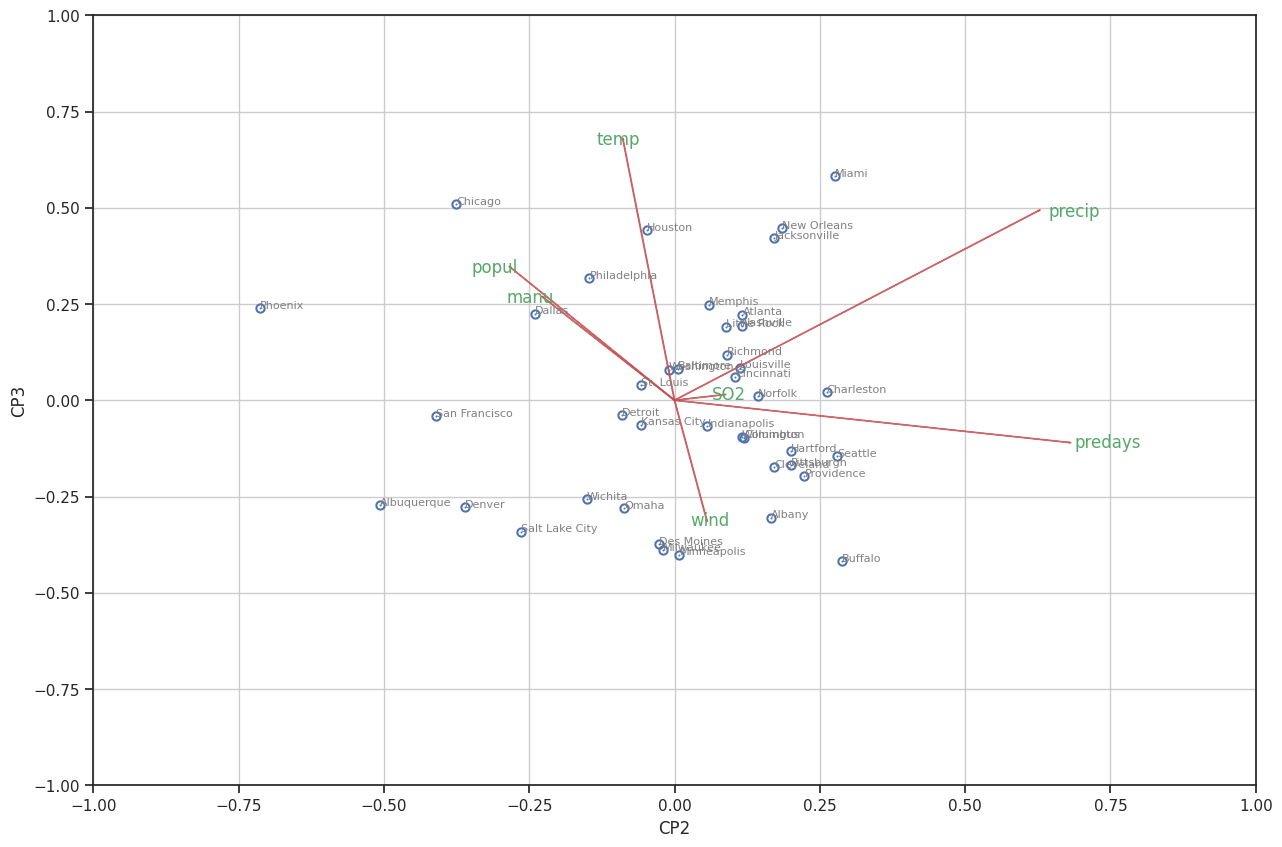

In [28]:
# biplot com nomes nas observações - Y2 e Y3
biplot_names(resultado_pca[:,[1, 2]],np.transpose(pca.components_[[1, 2], :]), list(X.columns), eixo_x='CP2', eixo_y='CP3')

## Diagramas de dispersão com tamanhos das bolhas

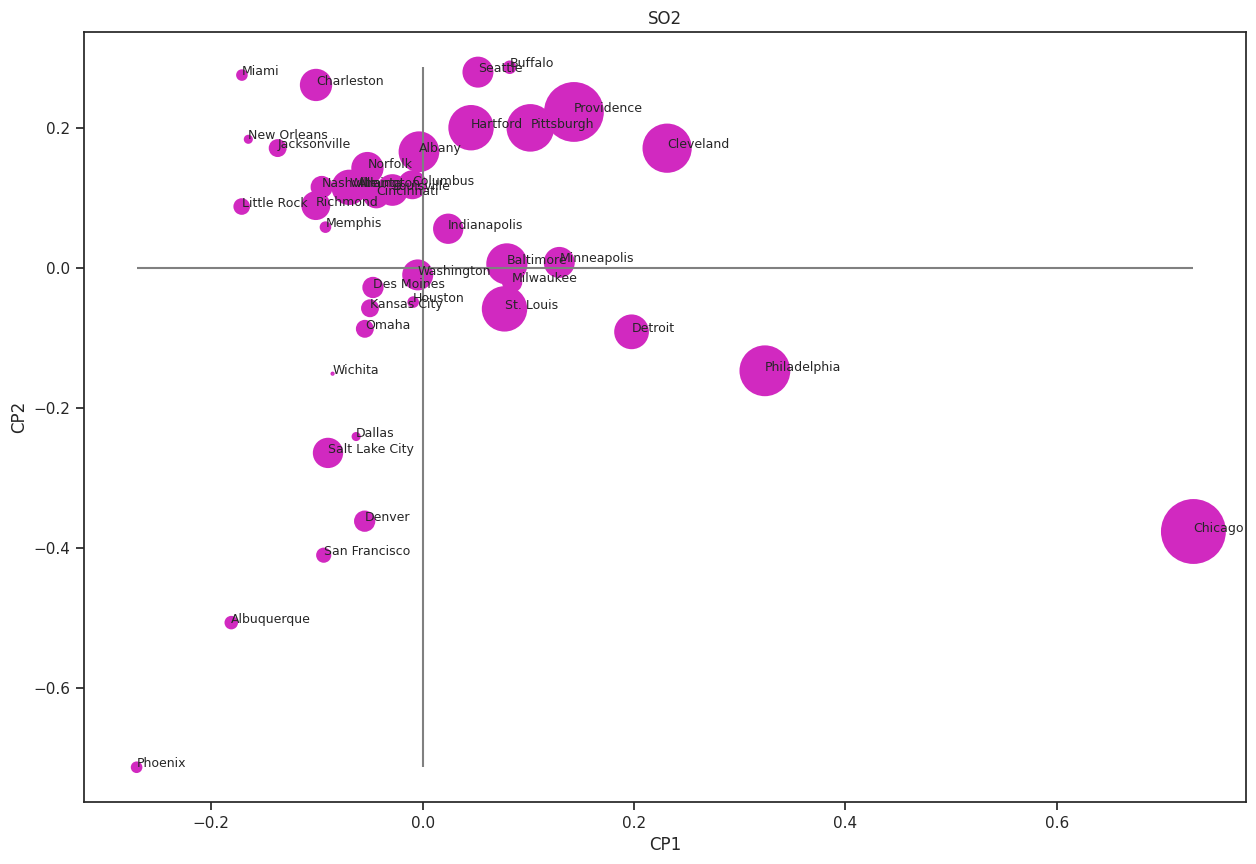

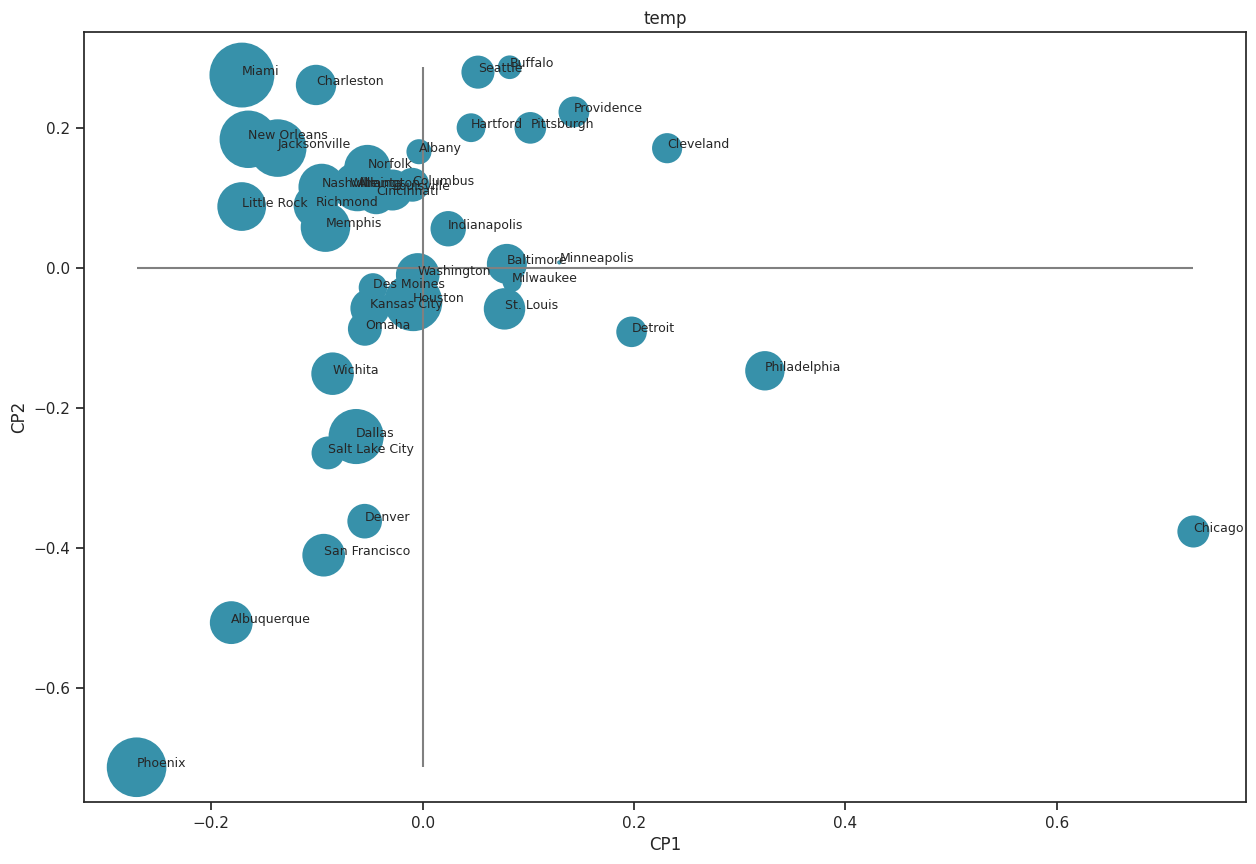

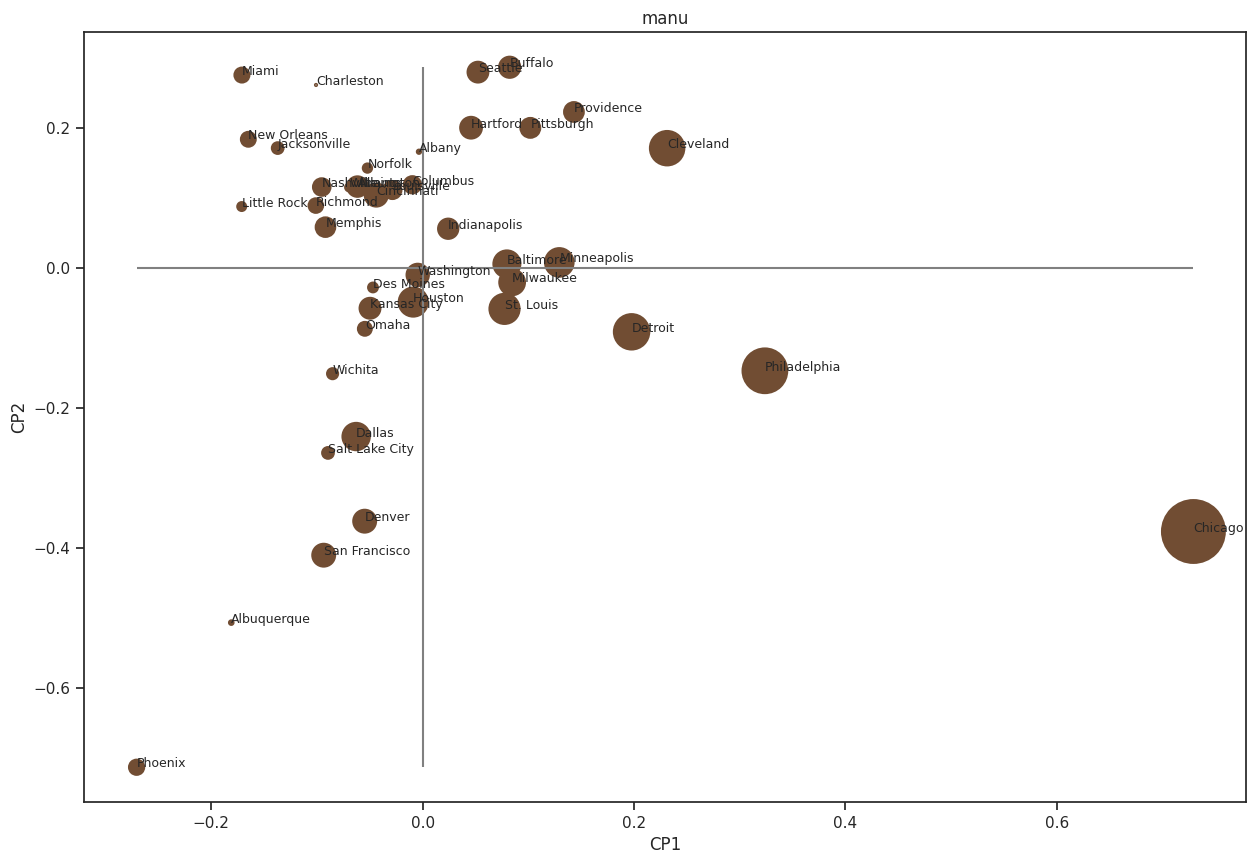

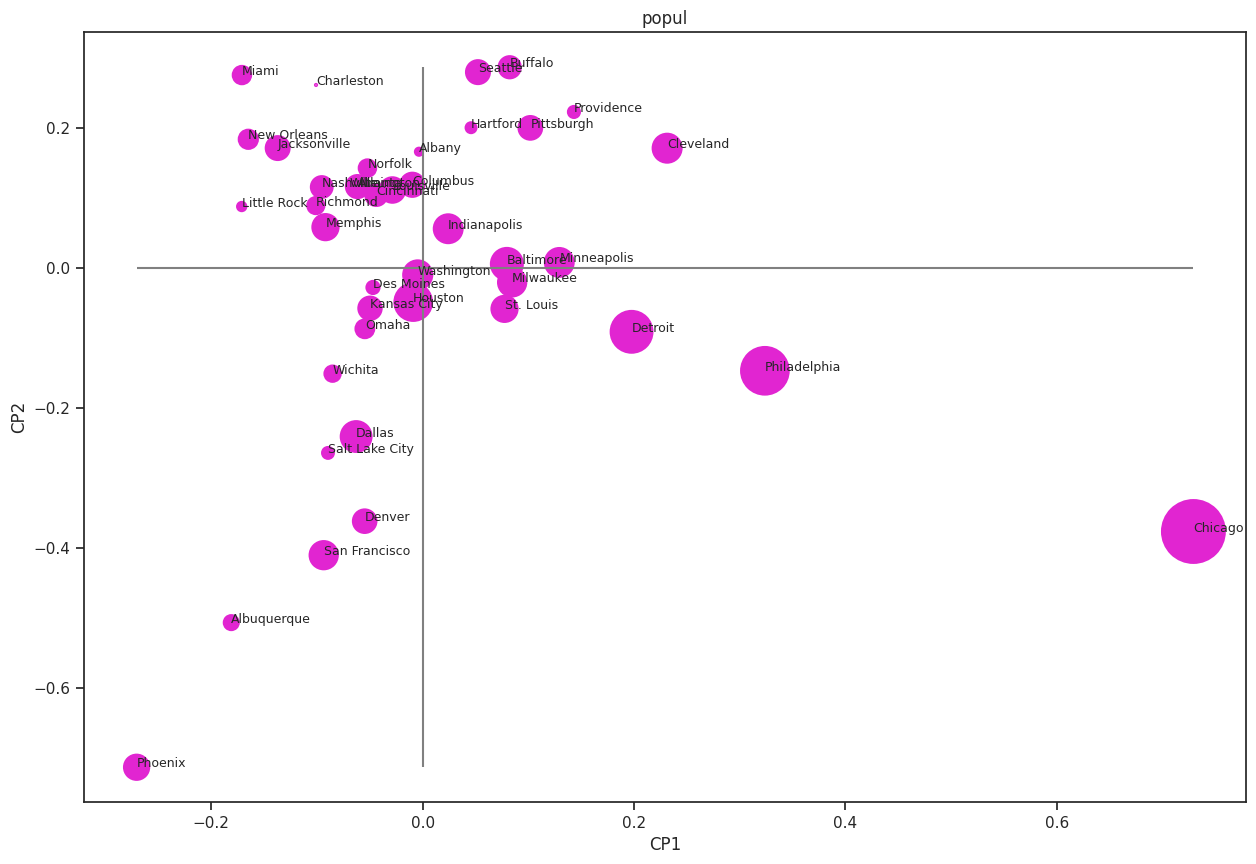

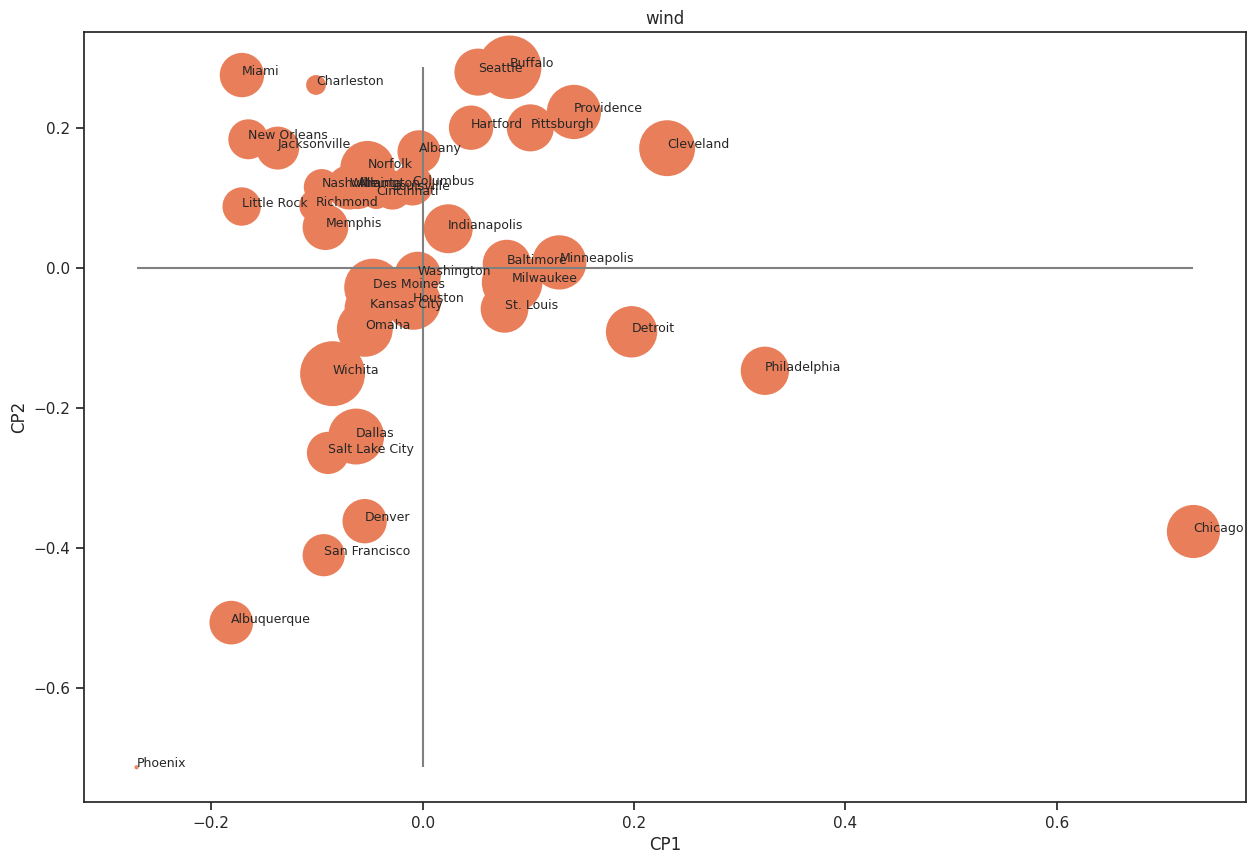

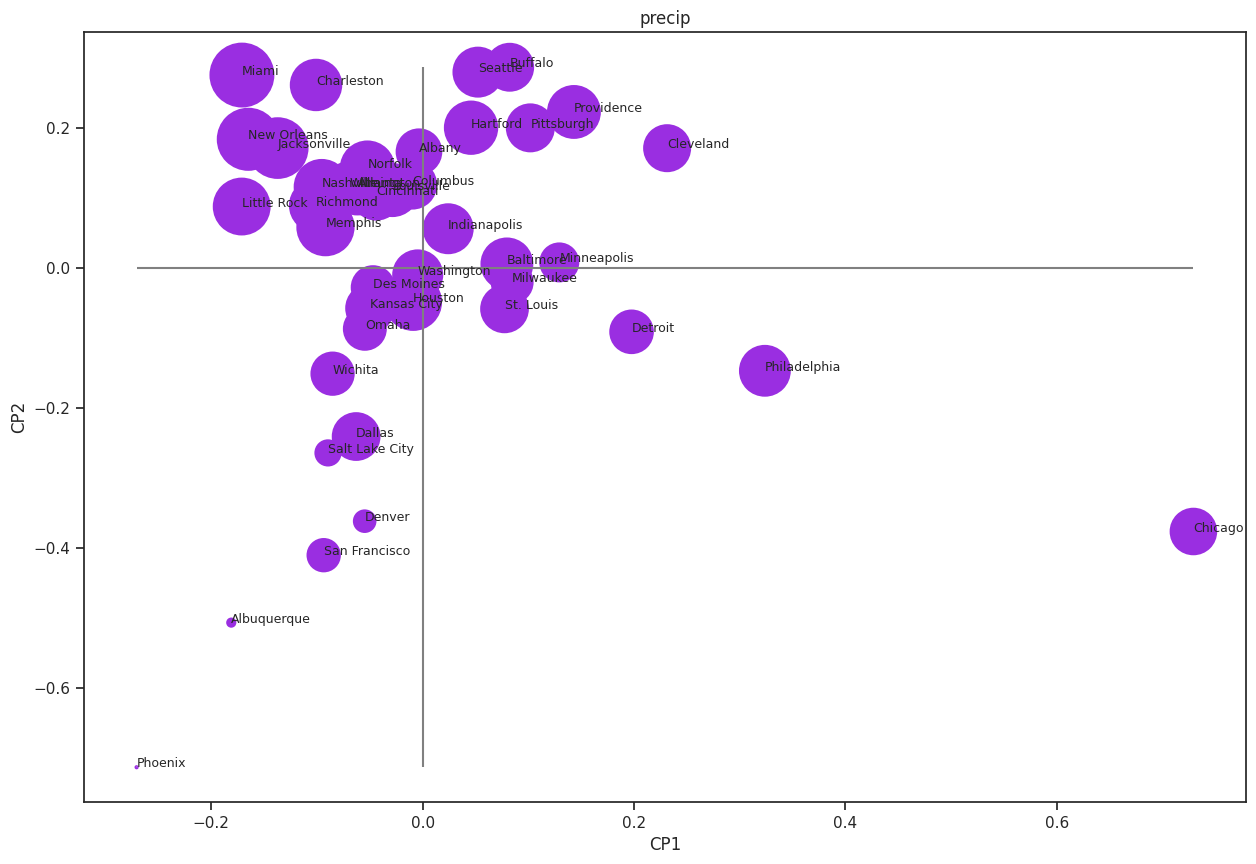

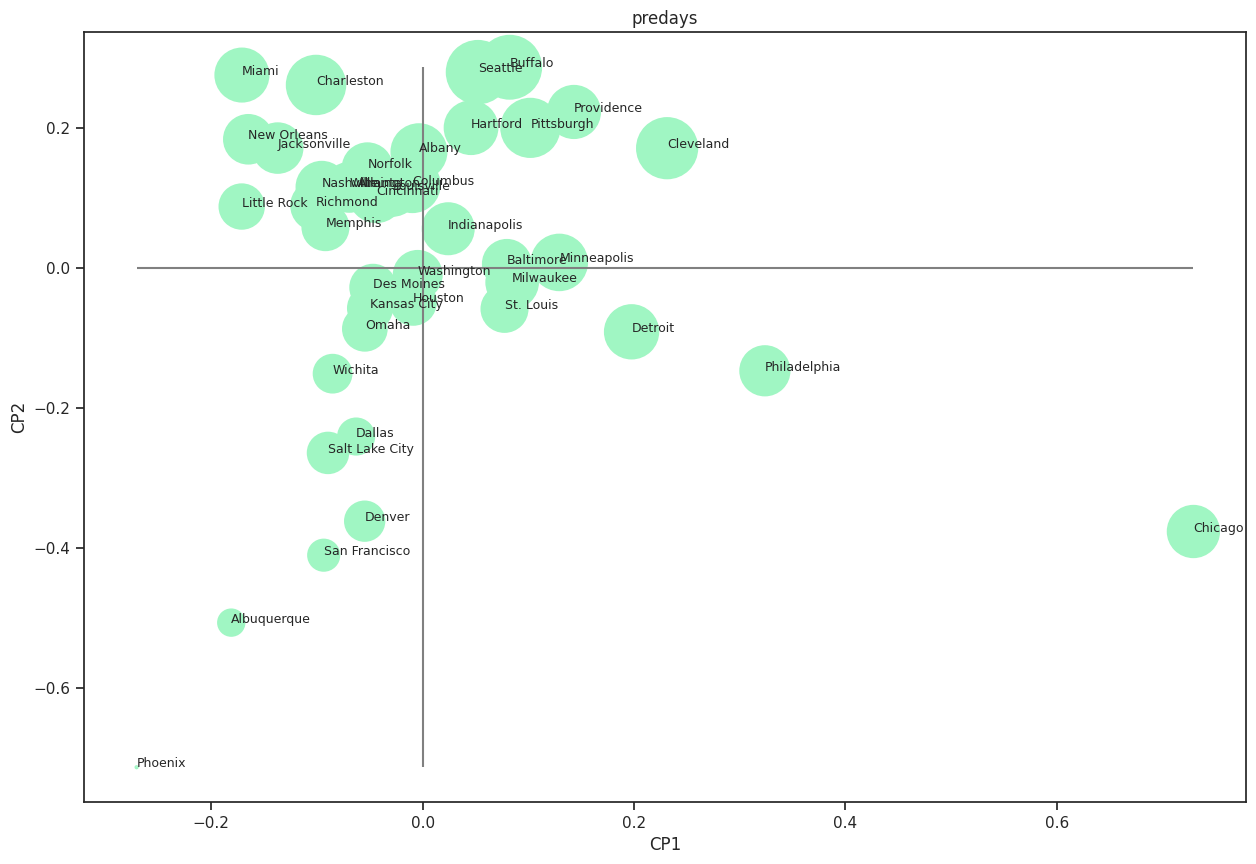

In [29]:
# diagramas de dispersão com bolhas
bubbles(dados, resultado)

# Dados de MG

Variáveis:

* rdpc: renda per capita média
* renocup: renda média dos ocupados
* pib_pc: PIB per capita
* fam_pbf: número de famílias que receberam benefício do bolsa família
* tx_emp_form: taxa de emprego no setor formal
* rend_pc_form: rendimento per capita no setor formal
* pop_total: número total de habitantes

In [30]:
# carregando o arquivo a partir de um endereço na internet
dados = pd.read_csv('https://patriciasiqueira.github.io/arquivos/imrs.csv', index_col='mun')
dados.shape

(853, 41)

Selecionar uma mesorregião:

In [31]:
# apenas a mesorregião de Sul de Minas
dados = dados.query("nome_meso == 'Sul/Sudoeste de Minas'")
dados.shape

(146, 41)

In [32]:
# selecionar apenas variáveis de interesse
dados = dados.loc[:, ['rdpc', 'renocup', 'pib_pc', 'fam_pbf', 'tx_emp_form', 'rend_pc_form', 'pop_total']]

Criar uma nova variável: taxa Bolsa-Família (dividir o número de famílias atendidas pelo BF pela população total) e multiplicar por 100

In [33]:
# taxa de famílias com BF
dados['tx_pbf'] = dados.fam_pbf / dados.pop_total * 100

In [34]:
# selecionar apenas variáveis de interesse - incluindo taxa de famílias atendidas pelo bolsa família
dados = dados.loc[:, ['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf', 'pop_total']]

In [35]:
dados.shape

(146, 7)

In [36]:
dados.head()

rdpc  renocup   pib_pc  tx_emp_form  rend_pc_form  tx_pbf  \
mun                                                                       
Aiuruoca    539.92   734.85  9477.41        19.80        113.90    4.58   
Alagoa      413.75   558.92  9395.80        15.70        103.43    9.71   
Albertina   564.08   796.26 14661.80        18.70        119.71    3.91   
Alfenas     783.41  1229.94 17398.74        33.50        314.28    4.43   
Alpinópolis 633.91  1029.25 12567.83        21.10        133.12    4.08   

             pop_total  
mun                     
Aiuruoca          6173  
Alagoa            2709  
Albertina         2913  
Alfenas          73722  
Alpinópolis      18490

In [37]:
dados.columns

Index(['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf',
       'pop_total'],
      dtype='object')

In [38]:
# verificar se tem algum valor faltante
dados.isnull().any()

rdpc            False
renocup         False
pib_pc          False
tx_emp_form     False
rend_pc_form    False
tx_pbf          False
pop_total       False
dtype: bool

Como neste caso não há valores faltantes, não precisaremos usar o código abaixo. Mas, se houvesse, iríamos substituir esses valores pela média da variável nos outros municípios.

In [39]:
# ver índices dos valores faltantes do dataframe
# faltantes = np.where(pd.isnull(mg['tx_med_lab']))

# ver nome do index dos valores faltantes
# mg.index[faltantes].tolist()

# substituir o valor faltante pela média dos outros
# media = mg[pd.notnull(mg['tx_med_lab'])].tx_med_lab.mean()
# mg['tx_med_lab'].fillna(media, inplace=True)

# verificar novamente depois da alteração
# mg.isnull().any()

## Análise exploratória

In [40]:
dados.describe()
# ou dados.describe().T

rdpc  renocup   pib_pc  tx_emp_form  rend_pc_form  tx_pbf  pop_total
count  146.00   146.00   146.00       146.00        146.00  146.00     146.00
mean   584.18   876.61 13405.99        23.28        152.71    6.07   16706.63
std    130.34   206.57  9686.16         9.02         94.59    2.24   23682.60
min    367.73   534.51  5666.74         8.90         51.67    1.42    1727.00
25%    496.13   732.14  8651.18        17.00         96.37    4.12    5220.50
50%    556.96   833.21 11028.65        21.60        121.41    5.70    9515.50
75%    642.56   970.84 13882.60        28.18        171.84    7.76   16837.00
max   1122.10  1671.92 72426.83        60.20        582.90   12.87  152496.00

In [41]:
dados.corr()

rdpc  renocup  pib_pc  tx_emp_form  rend_pc_form  tx_pbf  \
rdpc          1.00     0.94    0.39         0.61          0.57   -0.58   
renocup       0.94     1.00    0.42         0.61          0.59   -0.51   
pib_pc        0.39     0.42    1.00         0.54          0.76   -0.43   
tx_emp_form   0.61     0.61    0.54         1.00          0.86   -0.50   
rend_pc_form  0.57     0.59    0.76         0.86          1.00   -0.51   
tx_pbf       -0.58    -0.51   -0.43        -0.50         -0.51    1.00   
pop_total     0.64     0.61    0.26         0.55          0.54   -0.42   

              pop_total  
rdpc               0.64  
renocup            0.61  
pib_pc             0.26  
tx_emp_form        0.55  
rend_pc_form       0.54  
tx_pbf            -0.42  
pop_total          1.00

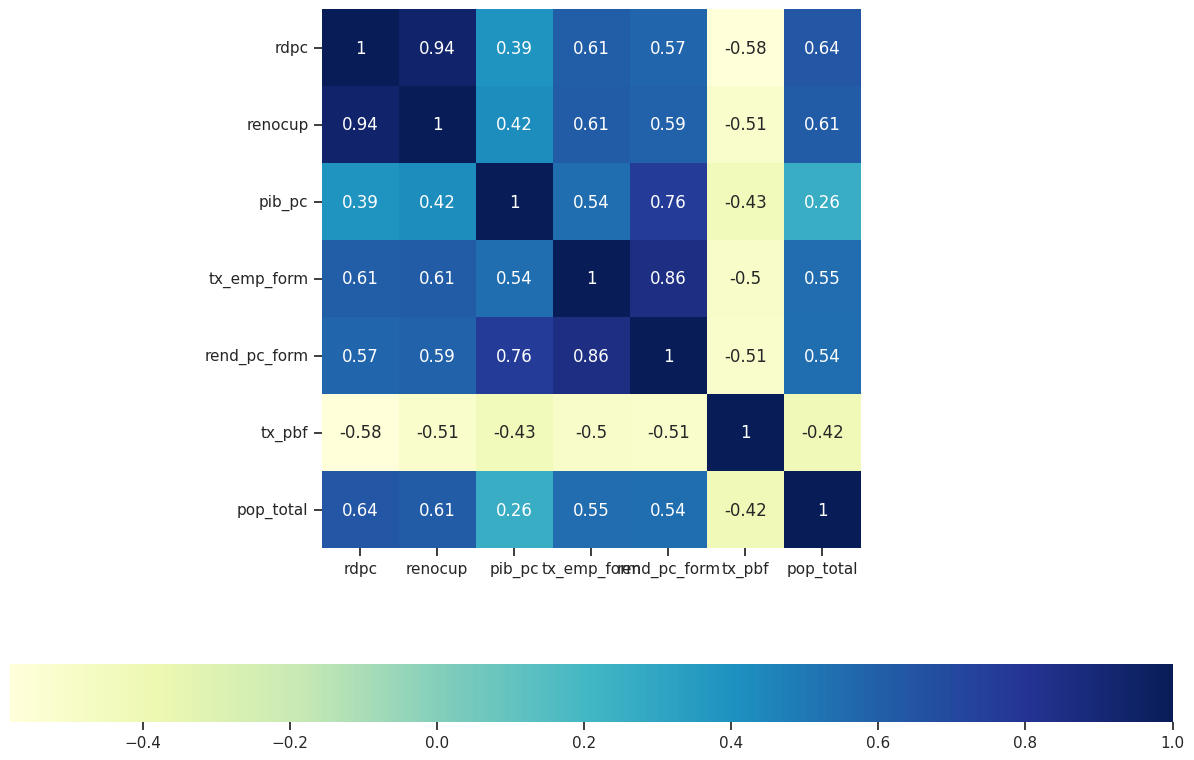

In [42]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(dados.corr(),
                 annot=True,
                 cmap='YlGnBu',
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

Quais as variáveis são mais correlacionadas? E menos?

Mais correlacionadas:

Menos correlacionadas:

In [43]:
# sns.set(style='ticks')
# sns.pairplot(dados);

Boxplots:

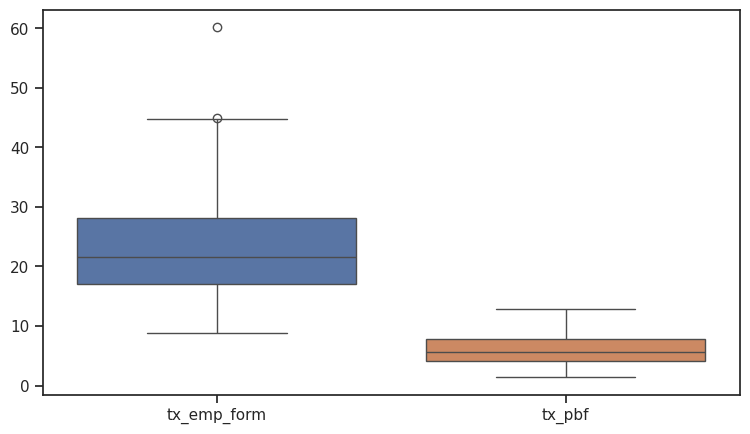

In [44]:
# variáveis em taxas
# boxplots
plt.figure(figsize=(9,5))
sns.boxplot(data=dados.loc[:,['tx_emp_form', 'tx_pbf']]);

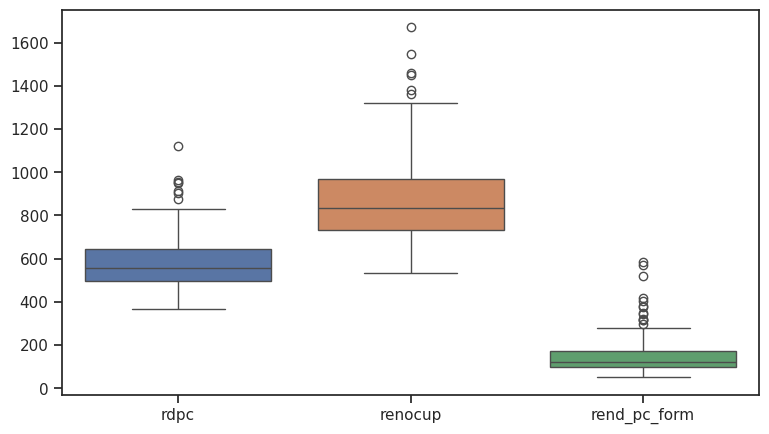

In [45]:
# variáveis de renda
# boxplots
plt.figure(figsize=(9,5))
sns.boxplot(data=dados.loc[:,['rdpc', 'renocup', 'rend_pc_form']]);

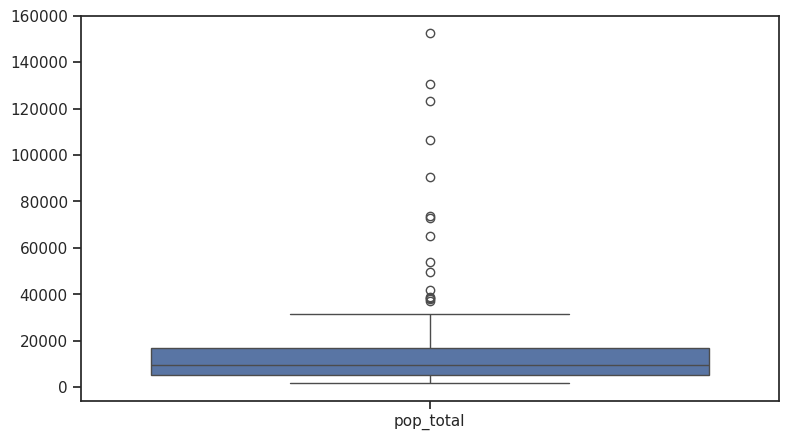

In [46]:
# população
plt.figure(figsize=(9,5))
sns.boxplot(data=dados.loc[:,['pop_total']]);

In [47]:
# visualizar apenas parte dos municípios (sem salvar)
dados.query('index == ["São Gonçalo do Sapucaí", "Três Pontas", "Campestre", "Varginha"]')

rdpc  renocup   pib_pc  tx_emp_form  rend_pc_form  \
mun                                                                          
Campestre              669.87   971.33 12366.55        18.40        109.71   
São Gonçalo do Sapucaí 648.31   979.10 14847.73        27.40        163.22   
Três Pontas            682.15  1055.69 13712.40        30.00        180.56   
Varginha               904.57  1382.27 32144.45        42.80        344.56   

                        tx_pbf  pop_total  
mun                                        
Campestre                 4.79      20701  
São Gonçalo do Sapucaí    5.39      23909  
Três Pontas               5.33      53825  
Varginha                  1.42     123120

### ACP usando a matriz de correlações (mais indicada)

Usando a matriz de correlações **R**

Pacote *scikit-learn*

In [48]:
# apenas mudando o nome do conjunto de dados para X
X = dados
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [49]:
X.columns

Index(['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf',
       'pop_total'],
      dtype='object')

In [50]:
dados.columns

Index(['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf',
       'pop_total'],
      dtype='object')

In [51]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.41,  0.41,  0.32,  0.4 ,  0.41, -0.33,  0.34],
       [-0.39, -0.35,  0.62,  0.2 ,  0.39,  0.02, -0.38],
       [-0.11, -0.01, -0.09,  0.29,  0.23,  0.82,  0.41],
       [-0.37, -0.49, -0.31,  0.22,  0.09, -0.45,  0.52],
       [ 0.05,  0.06, -0.53,  0.64,  0.1 , -0.04, -0.54],
       [ 0.09, -0.03, -0.35, -0.5 ,  0.78, -0.01, -0.11],
       [ 0.72, -0.68,  0.07,  0.05, -0.04,  0.1 , -0.02]])

In [52]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([4.45, 1.  , 0.61, 0.49, 0.35, 0.08, 0.06])

In [53]:
# a soma das variâncias deve ser próxima de p, o número de variáveis
pca.explained_variance_.sum()

np.float64(7.048275862068968)

In [54]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([63.16, 77.34, 86.03, 93.01, 98.03, 99.2 , 99.99])

In [55]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.41  0.41  0.32  0.4   0.41 -0.33  0.34]
 [-0.39 -0.35  0.62  0.2   0.39  0.02 -0.38]
 [-0.11 -0.01 -0.09  0.29  0.23  0.82  0.41]]


In [56]:
X.columns

Index(['rdpc', 'renocup', 'pib_pc', 'tx_emp_form', 'rend_pc_form', 'tx_pbf',
       'pop_total'],
      dtype='object')

In [57]:
# escores dos dois primeiros CPs
# resultado

## Análise gráfica dos componentes

### Gráfico da variância acumulada

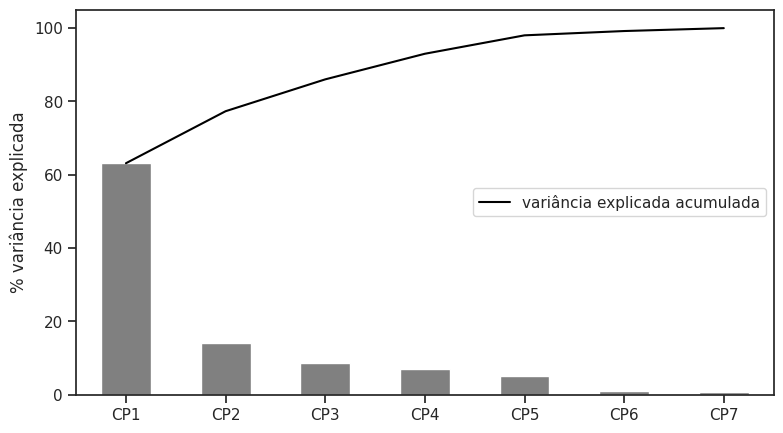

In [58]:
# variâncias acumuladas
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot com %
fig, ax = plt.subplots(figsize=(9,5))
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='center right',)
plt.ylabel('% variância explicada')
plt.xlabel('');

### *Scree plot*

O *Scree plot* é um gráfico com os autovalores de cada componente

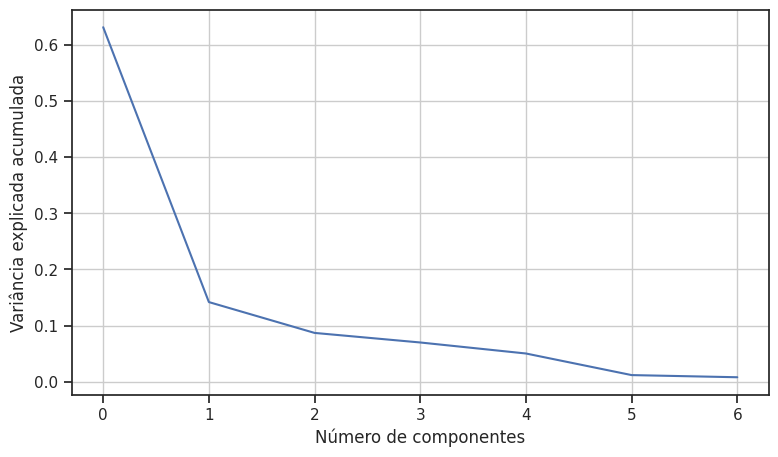

In [59]:
plt.figure(figsize=(9,5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.grid()
plt.show()

### Diagrama de dispersão entre CP1 e CP2

Nesse gráfico vamos visualizar a relação entre os dois primeiros CPs.

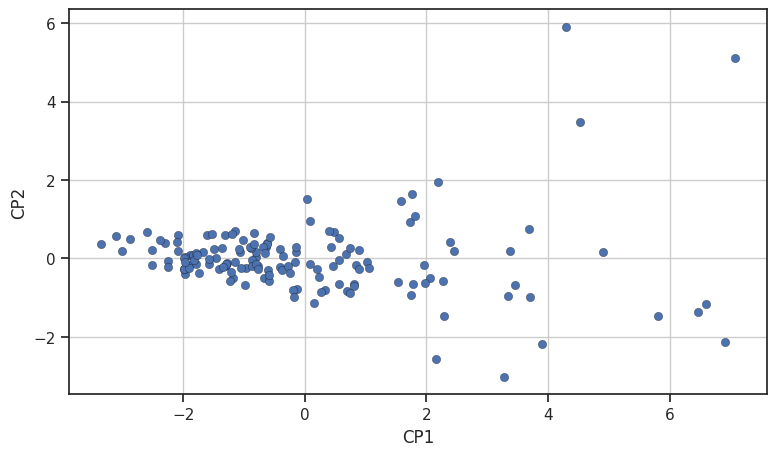

In [60]:
plt.figure(figsize=(9,5))
plt.scatter(resultado_pca[:, 0], resultado_pca[:, 1], edgecolors='black', linewidths=.2);
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.grid();

### Efeito das variáveis em cada componente

O atributo 'components_' nos dá os autovetores que representam a direção de máxima variância dos dados. Ao verificar a correlação dos componentes com as variáveis originais podemos ver a influência que cada variável tem sobre os componentes.

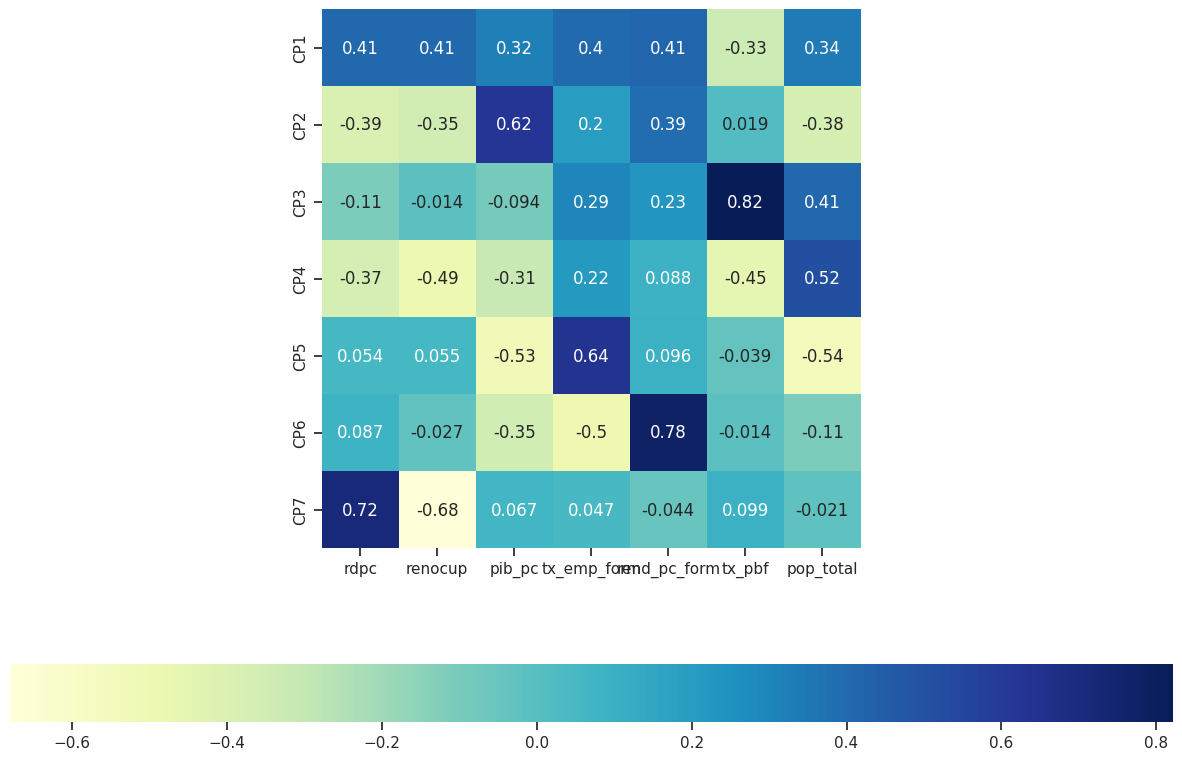

In [61]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(pca.components_,
                 annot=True,
                 cmap='YlGnBu',
                 yticklabels=[ "CP"+str(X) for X in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

### ACP *Biplot*

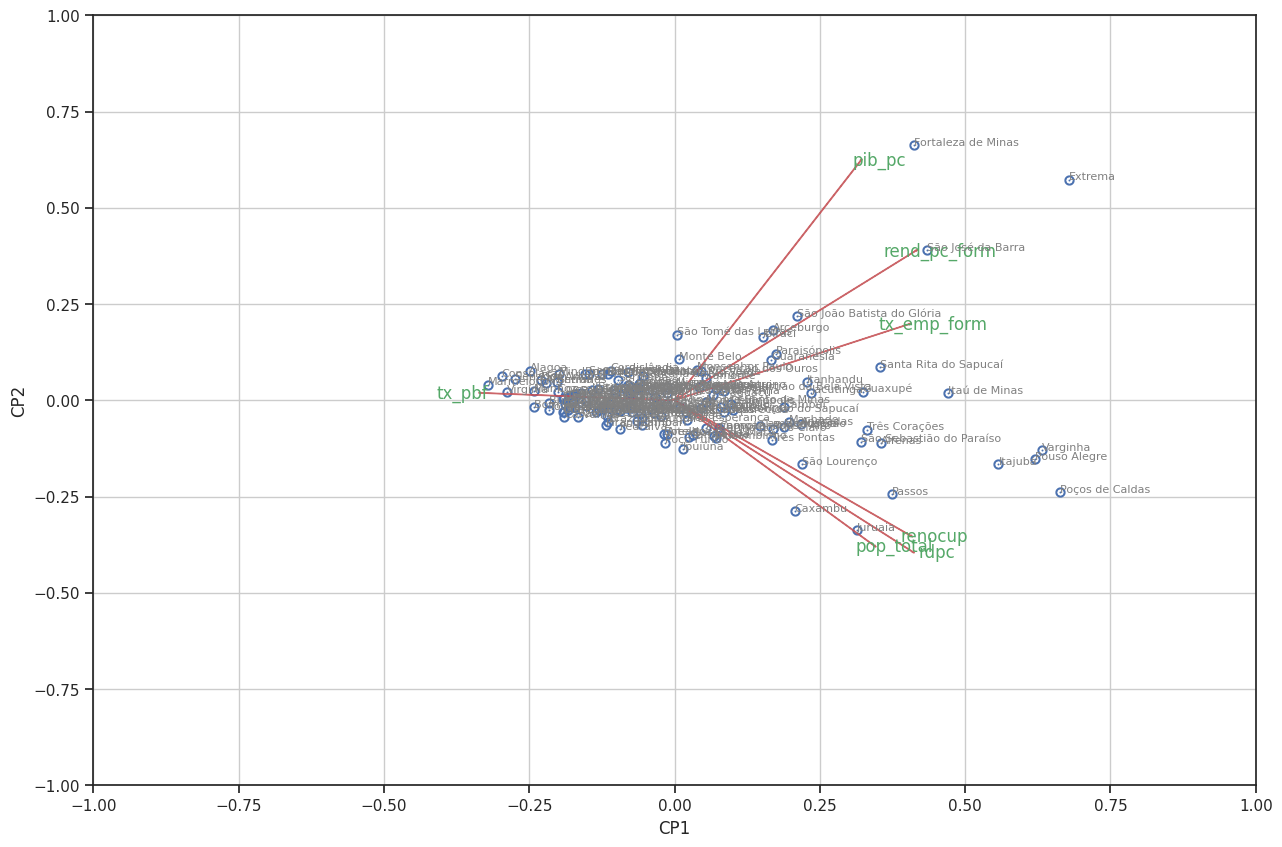

In [62]:
# biplot com nomes nas observações
biplot_names(resultado_pca[:,0:2], np.transpose(pca.components_[0:2, :]), list(X.columns))

Diagrama de dispersão dos escores com escala padronizada

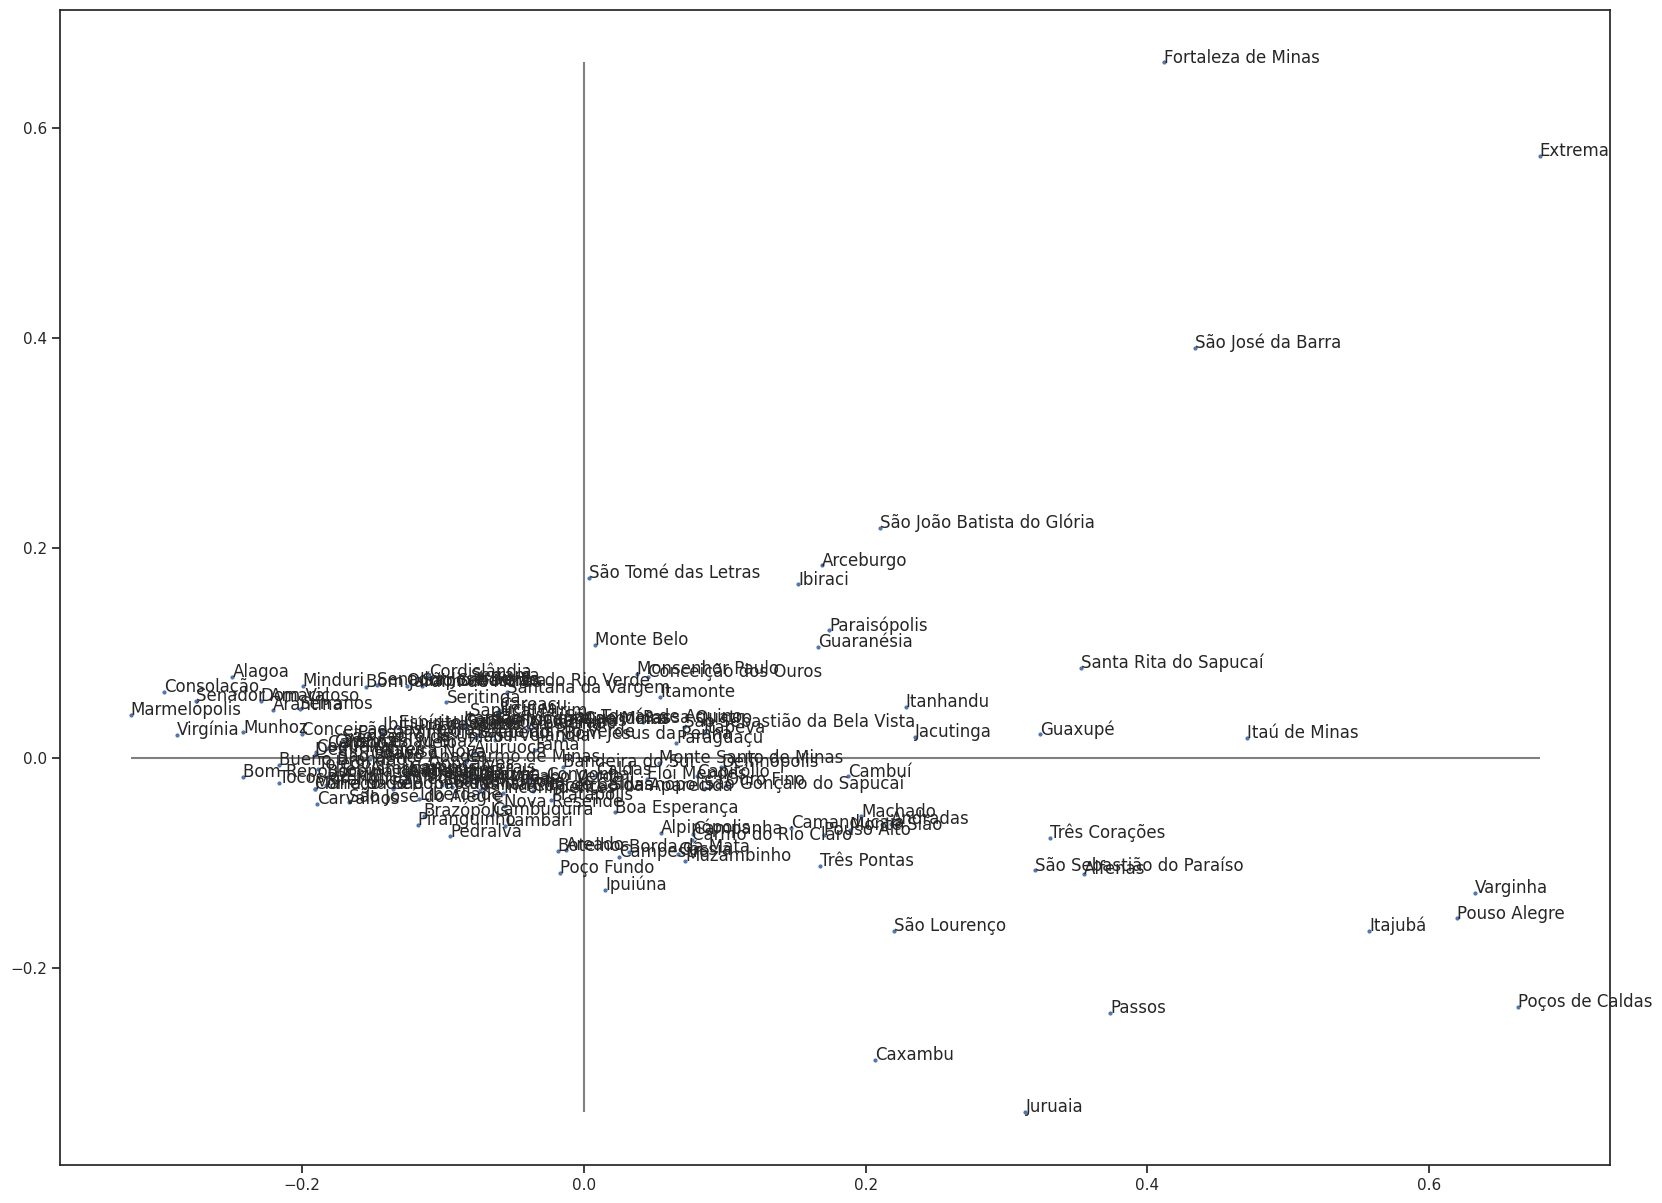

In [63]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
xs = resultado.iloc[:,0]
ys = resultado.iloc[:,1]
scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
xx = xs*scalex
yy = ys*scaley
ax.scatter(xx, yy, s=1, linewidths=2)
for i, txt in enumerate(resultado.index):
    ax.annotate(txt, (xx.iloc[i], yy.iloc[i]))
plt.hlines(0, xx.min(), xx.max(), color='gray')
plt.vlines(0, yy.min(), yy.max(), color='gray');

## Diagramas de dispersão com tamanhos das bolhas

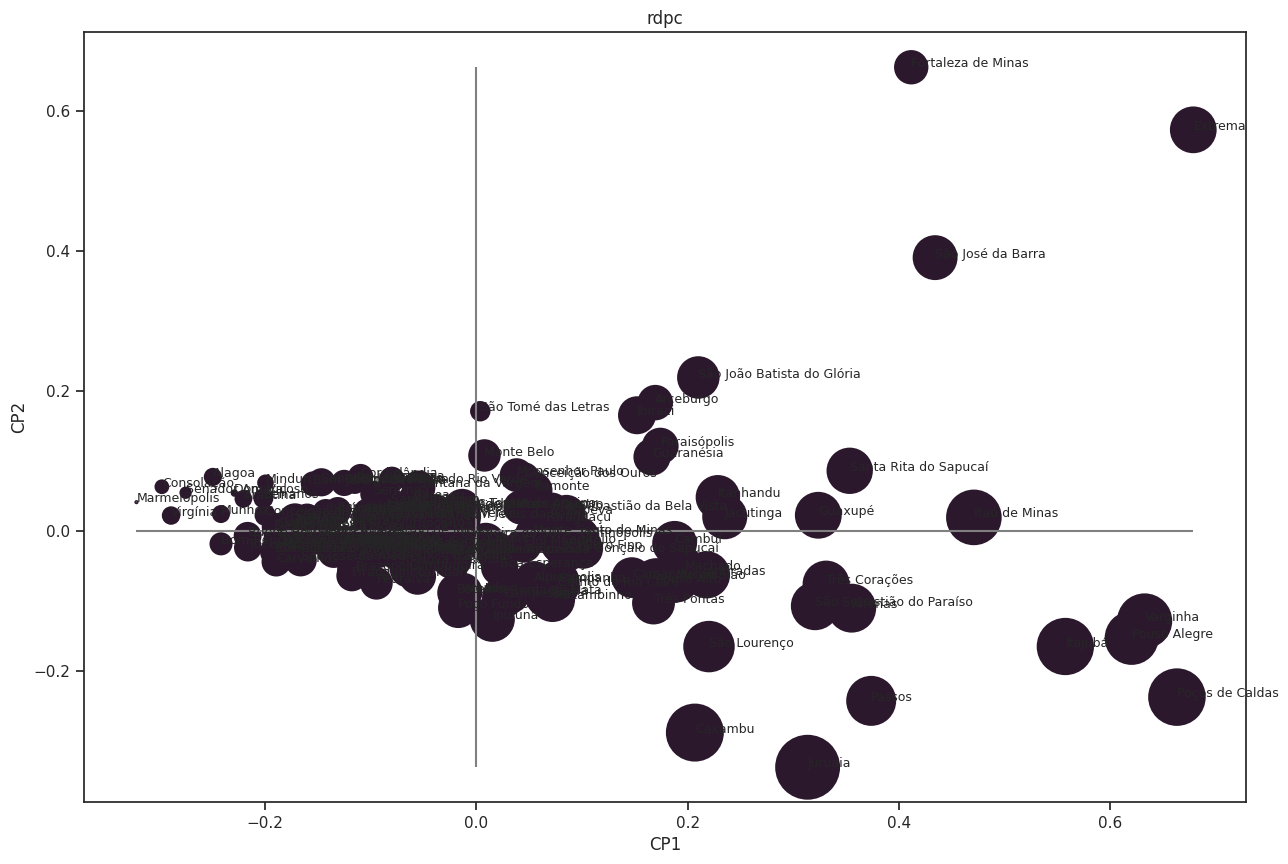

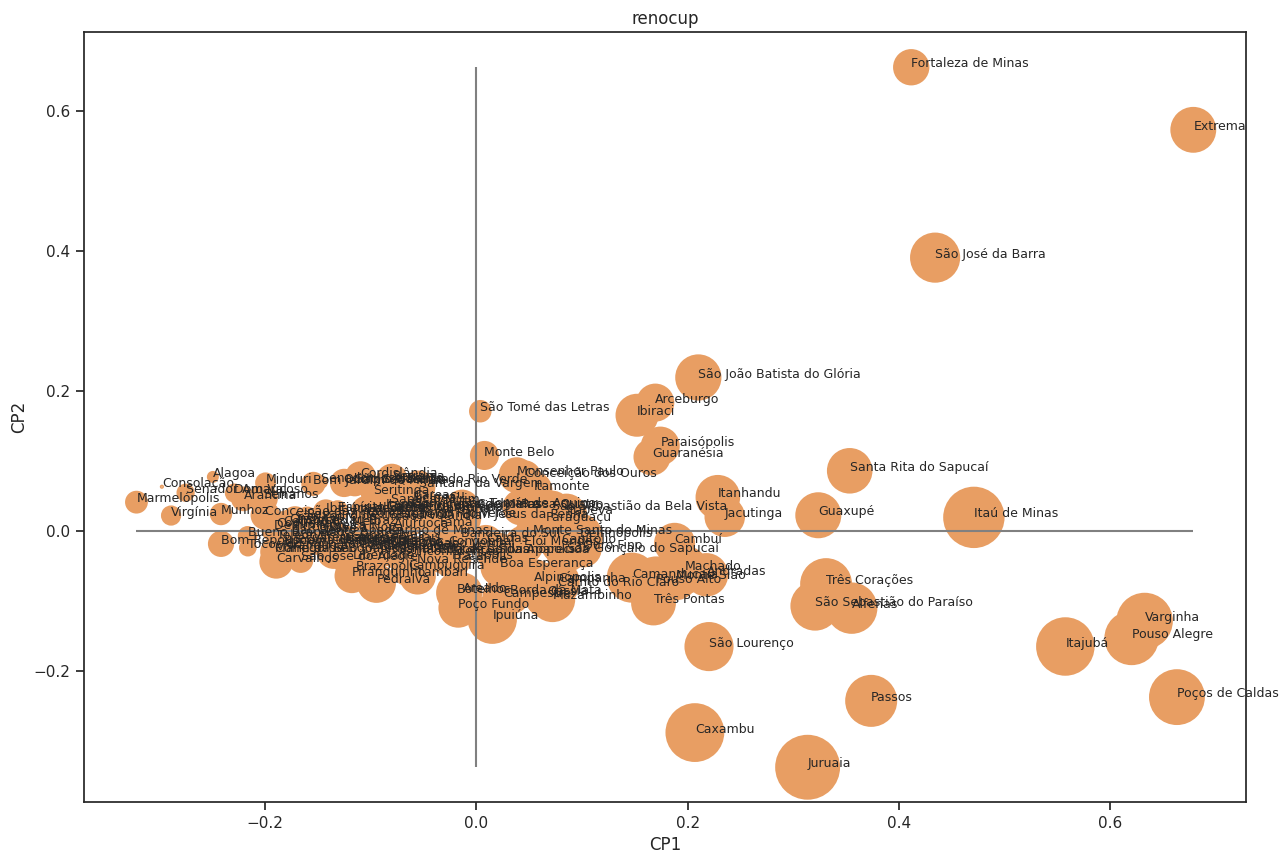

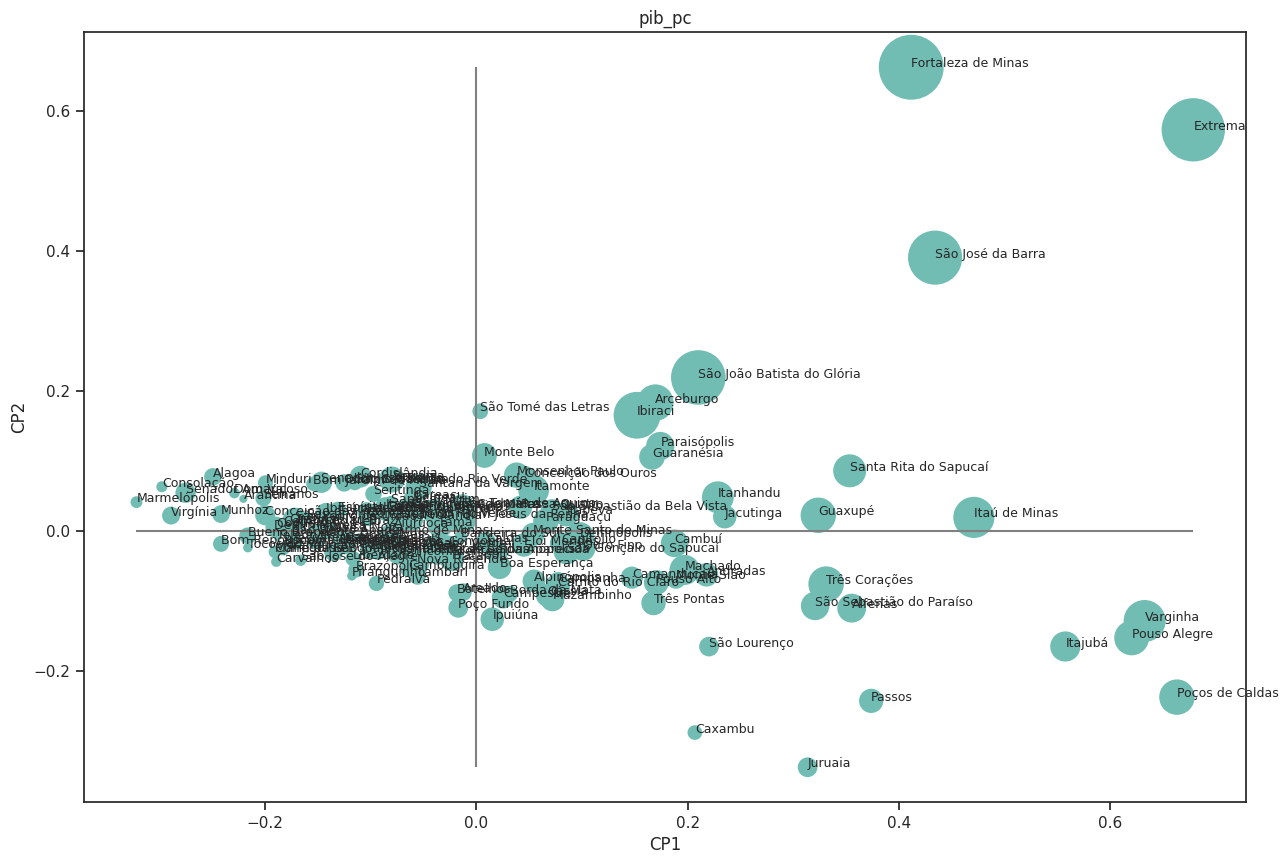

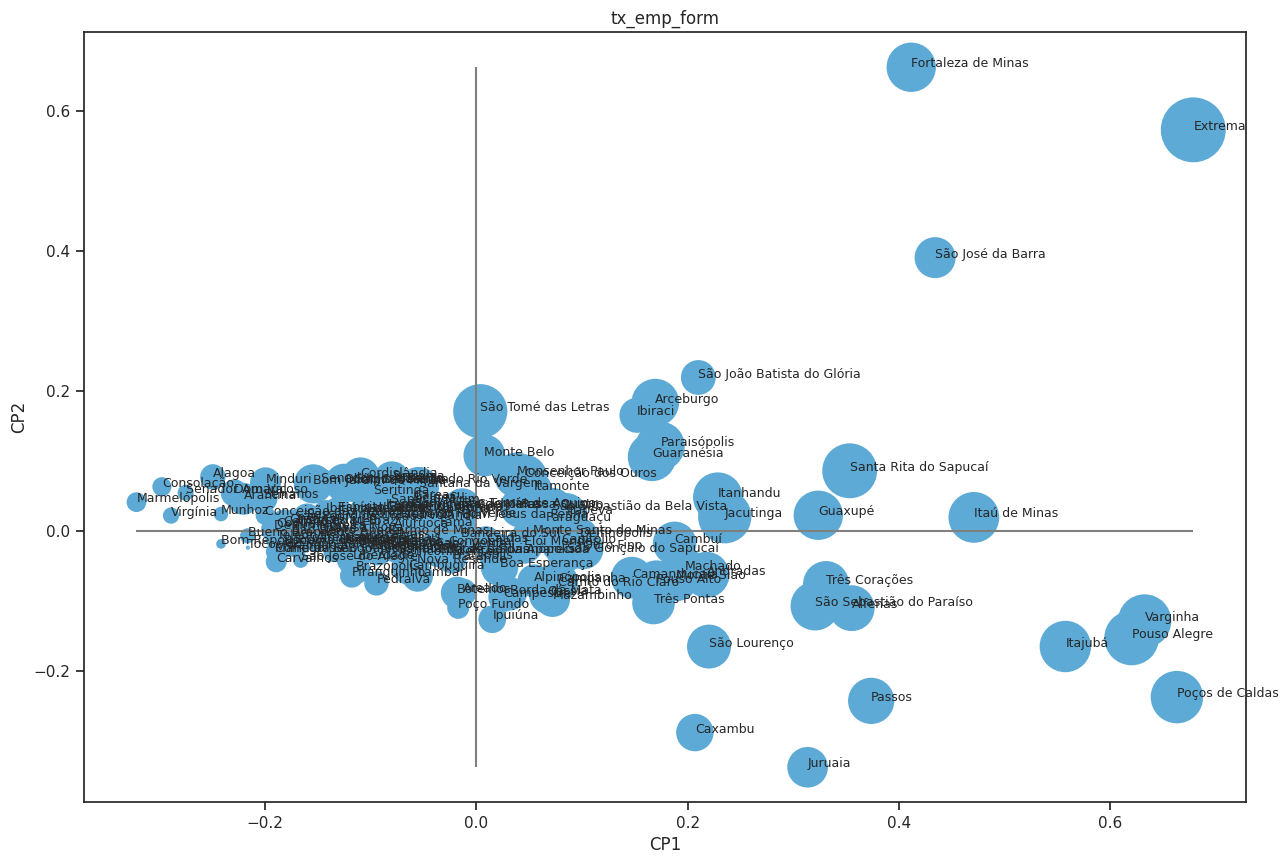

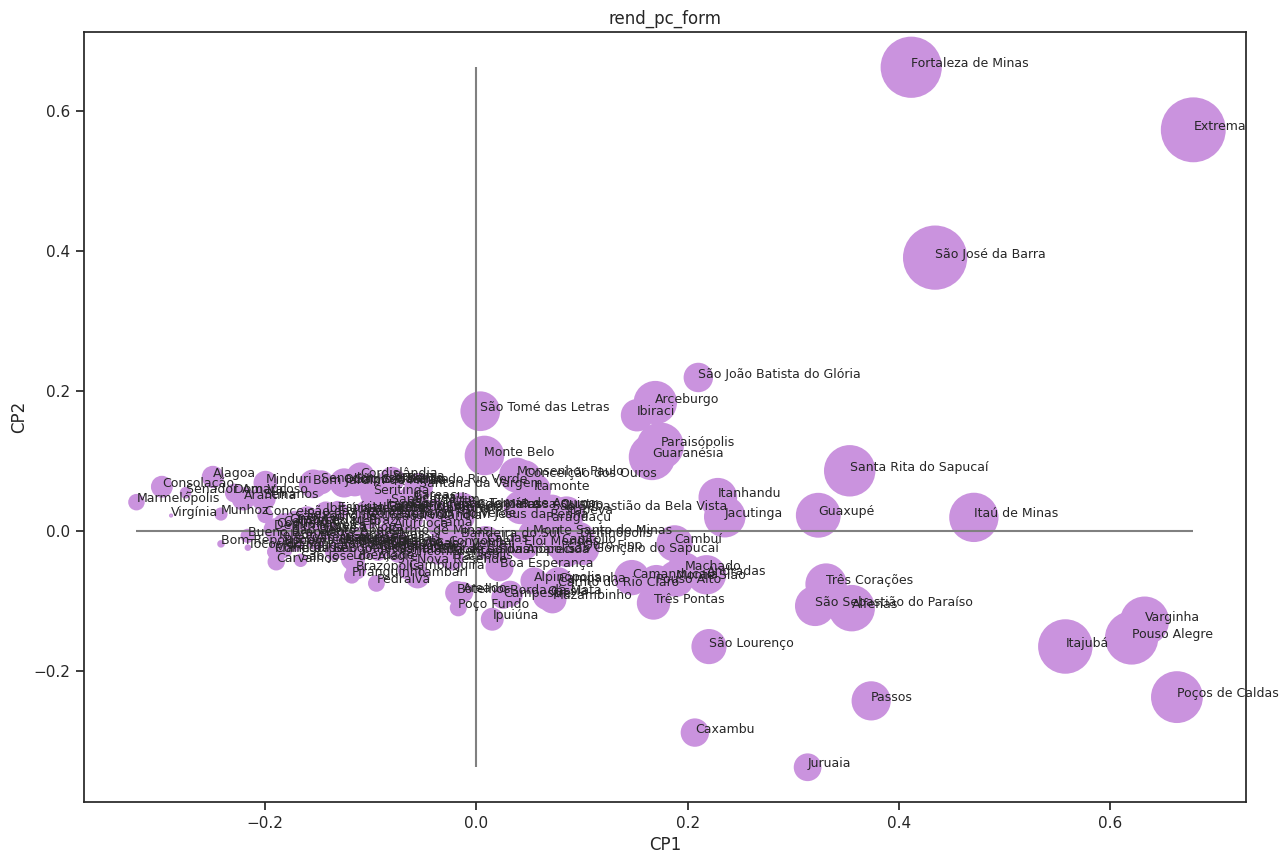

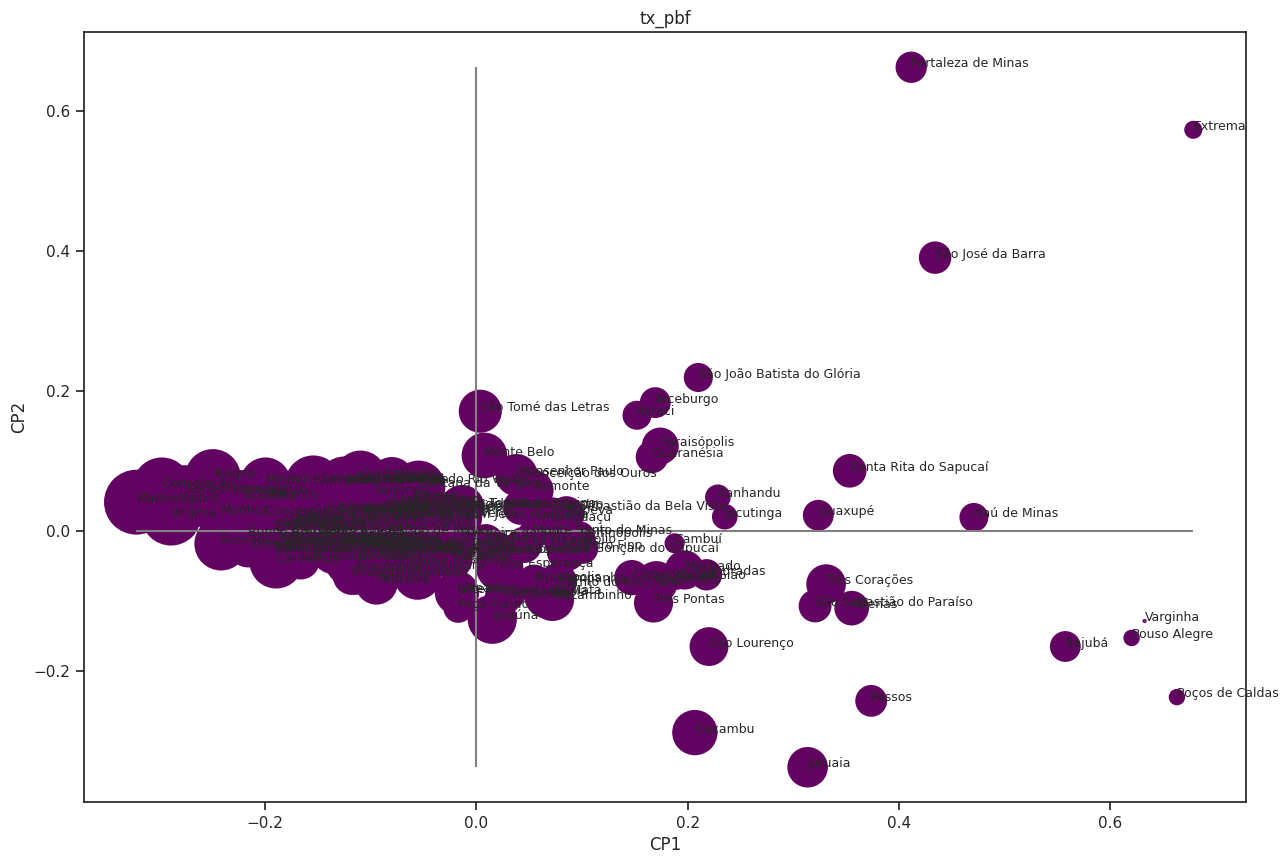

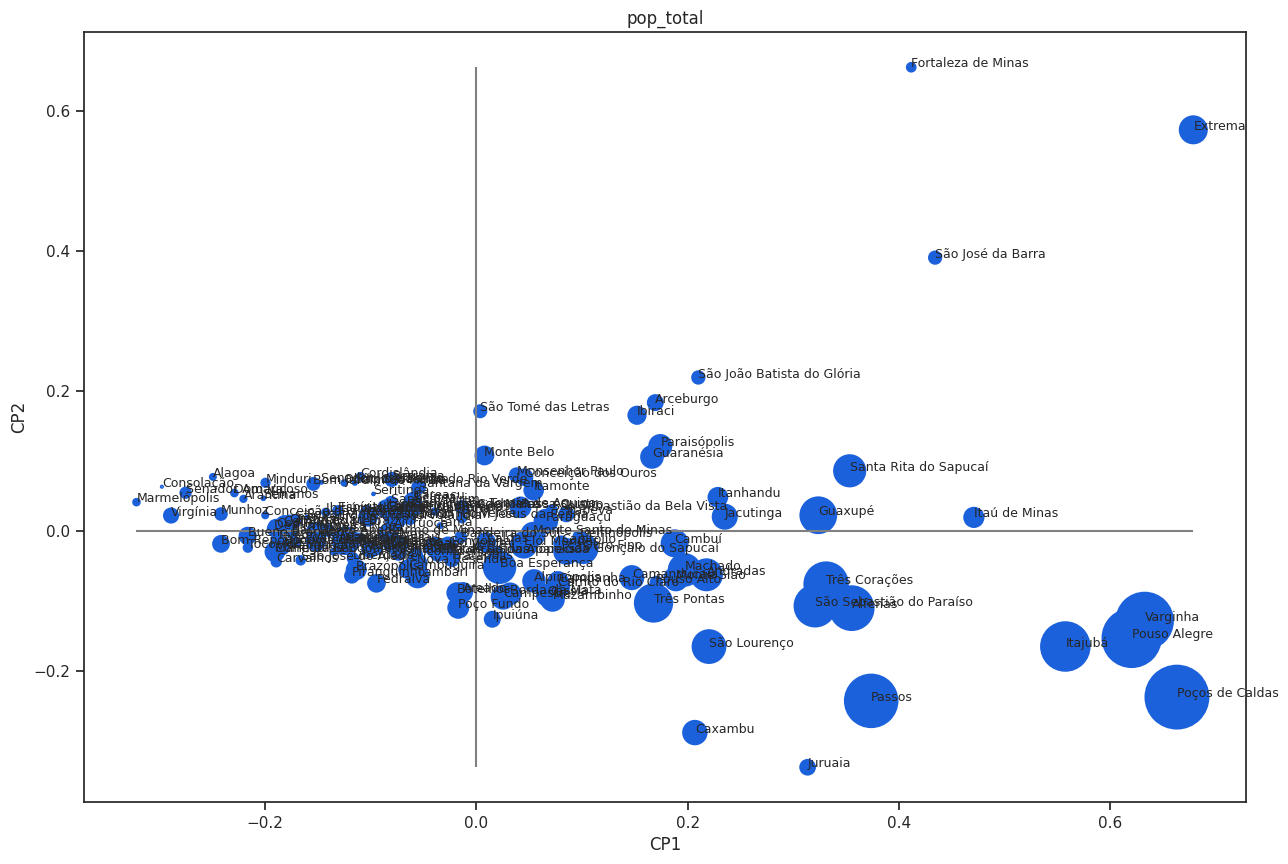

In [64]:
bubbles(dados, resultado)

In [65]:
# resultado.sort_values(by='cp1', ascending=True)

In [66]:
dados.query("index == ['Poços de Caldas', 'Varginha', 'Extrema', 'Fortaleza de Minas', 'São Tomé das Letras', 'Marmelópolis']")

rdpc  renocup   pib_pc  tx_emp_form  rend_pc_form  \
mun                                                                       
Extrema             745.21  1081.48 69063.46        60.20        582.90   
Fortaleza de Minas  562.53   865.98 72426.83        37.70        521.53   
Marmelópolis        367.73   652.47  7055.09        12.70         77.41   
Poços de Caldas     953.96  1364.19 24079.16        41.70        382.96   
São Tomé das Letras 428.33   648.83  8559.06        44.00        239.46   
Varginha            904.57  1382.27 32144.45        42.80        344.56   

                     tx_pbf  pop_total  
mun                                     
Extrema                2.10      28564  
Fortaleza de Minas     3.83       4098  
Marmelópolis          12.87       2968  
Poços de Caldas        1.96     152496  
São Tomé das Letras    6.24       6655  
Varginha               1.42     123120

In [67]:
dados.describe()

rdpc  renocup   pib_pc  tx_emp_form  rend_pc_form  tx_pbf  pop_total
count  146.00   146.00   146.00       146.00        146.00  146.00     146.00
mean   584.18   876.61 13405.99        23.28        152.71    6.07   16706.63
std    130.34   206.57  9686.16         9.02         94.59    2.24   23682.60
min    367.73   534.51  5666.74         8.90         51.67    1.42    1727.00
25%    496.13   732.14  8651.18        17.00         96.37    4.12    5220.50
50%    556.96   833.21 11028.65        21.60        121.41    5.70    9515.50
75%    642.56   970.84 13882.60        28.18        171.84    7.76   16837.00
max   1122.10  1671.92 72426.83        60.20        582.90   12.87  152496.00

# Dados de MG: retirando as variáveis mais correlacionadas

In [68]:
# carregando o arquivo a partir de um endereço na internet
dados = pd.read_csv('https://patriciasiqueira.github.io/arquivos/imrs.csv', index_col='mun')

Selecionar uma mesorregião:

In [69]:
# apenas a mesorregião de Sul de Minas
dados = dados.query("nome_meso == 'Sul/Sudoeste de Minas'")

In [70]:
# selecionar apenas variáveis de interesse
dados = dados.loc[:, ['rdpc', 'renocup', 'pib_pc', 'fam_pbf', 'tx_emp_form', 'rend_pc_form', 'pop_total']]

Criar uma nova variável: taxa Bolsa-Família (dividir o número de famílias atendidas pelo BF pela população total) e multiplicar por 100

In [71]:
# taxa de famílias com BF
dados['tx_pbf'] = dados.fam_pbf / dados.pop_total * 100

In [72]:
# retirar renocup e rend_pc_form, que têm alta correlação com outras
dados = dados.loc[:, ['rdpc', 'pib_pc', 'tx_emp_form', 'tx_pbf', 'pop_total']]

In [73]:
dados.shape

(146, 5)

In [74]:
dados.head()

rdpc   pib_pc  tx_emp_form  tx_pbf  pop_total
mun                                                        
Aiuruoca    539.92  9477.41        19.80    4.58       6173
Alagoa      413.75  9395.80        15.70    9.71       2709
Albertina   564.08 14661.80        18.70    3.91       2913
Alfenas     783.41 17398.74        33.50    4.43      73722
Alpinópolis 633.91 12567.83        21.10    4.08      18490

In [75]:
dados.columns

Index(['rdpc', 'pib_pc', 'tx_emp_form', 'tx_pbf', 'pop_total'], dtype='object')

### ACP usando a matriz de correlações (mais indicada)

Usando a matriz de correlações **R**

Pacote *scikit-learn*

In [76]:
# apenas mudando o nome do conjunto de dados para X
X = dados
pca = PCA(random_state=1)
resultado_pca = pca.fit_transform(scale(X))   # scale(X) padroniza os dados, como se usássemos a matriz R
resultado = pd.DataFrame({'cp1':resultado_pca[:, 0], 'cp2':resultado_pca[:, 1]}, index=X.index)

In [77]:
X.columns

Index(['rdpc', 'pib_pc', 'tx_emp_form', 'tx_pbf', 'pop_total'], dtype='object')

In [78]:
# coeficientes dos CPs (autovetores)
# cada linha é um CP
pca.components_

array([[ 0.49,  0.38,  0.48, -0.44,  0.43],
       [-0.28,  0.76,  0.11, -0.1 , -0.57],
       [-0.1 ,  0.25,  0.38,  0.83,  0.31],
       [-0.15, -0.47,  0.78, -0.09, -0.38],
       [ 0.8 , -0.02, -0.06,  0.32, -0.5 ]])

In [79]:
# variâncias dos CPs (autovalores)
pca.explained_variance_

array([3.  , 0.8 , 0.56, 0.35, 0.32])

In [80]:
# a soma das variâncias deve ser próxima de p, o número de variáveis)
pca.explained_variance_.sum()

np.float64(5.034482758620691)

In [81]:
# variância explicada acumulada
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 59.64,  75.59,  86.72,  93.67, 100.  ])

In [82]:
# os três primeiros CPs
print(pca.components_[0:3, :])

[[ 0.49  0.38  0.48 -0.44  0.43]
 [-0.28  0.76  0.11 -0.1  -0.57]
 [-0.1   0.25  0.38  0.83  0.31]]


In [83]:
X.columns

Index(['rdpc', 'pib_pc', 'tx_emp_form', 'tx_pbf', 'pop_total'], dtype='object')

In [84]:
# escores dos dois primeiros CPs
# resultado

## Análise gráfica dos componentes

### Gráfico da variância acumulada

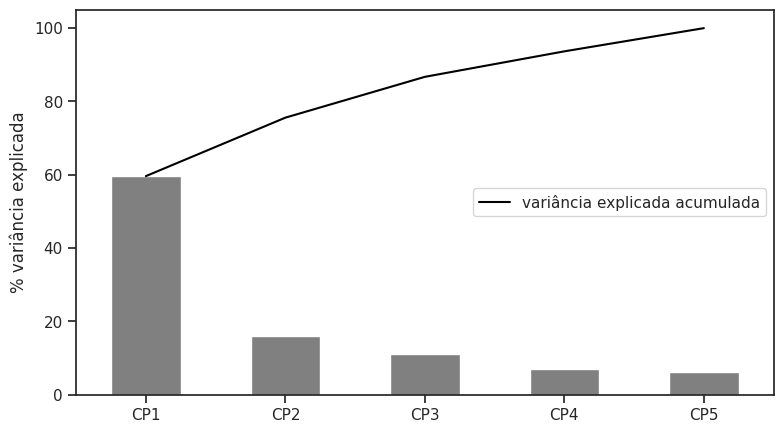

In [85]:
# variâncias acumuladas
tot = sum(pca.explained_variance_)
var_exp = [(i / tot)*100 for i in sorted(pca.explained_variance_, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
# número de CPs gerados (k = p)
cp =['CP'+str(i+1) for i in range(len(pca.components_))]
# dataframe com as variâncias acumuladas para criar o scree plot
df = pd.DataFrame({'cp': cp, 'var_exp': var_exp, 'cum_var_exp': cum_var_exp})
# scree plot com %
fig, ax = plt.subplots(figsize=(9,5))
df.plot.bar('cp', 'var_exp', color='gray', ax=ax, legend=False)
df.plot.line('cp', 'cum_var_exp', color='black', ax=ax)
plt.legend(labels=['variância explicada acumulada'],
           loc='center right',)
plt.ylabel('% variância explicada')
plt.xlabel('');

### *Scree plot*

O *Scree plot* é um gráfico com os autovalores de cada componente

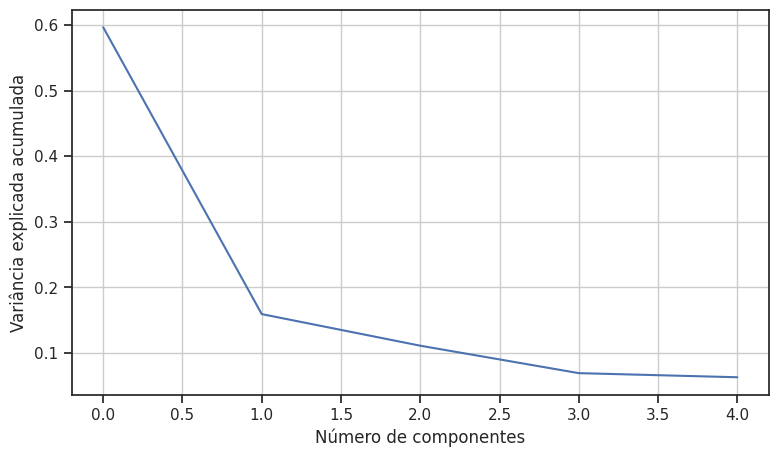

In [86]:
plt.figure(figsize=(9,5))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Número de componentes')
plt.ylabel('Variância explicada acumulada')
plt.grid()
plt.show()

### Diagrama de dispersão entre CP1 e CP2

Nesse gráfico vamos visualizar a relação entre os dois primeiros CPs.

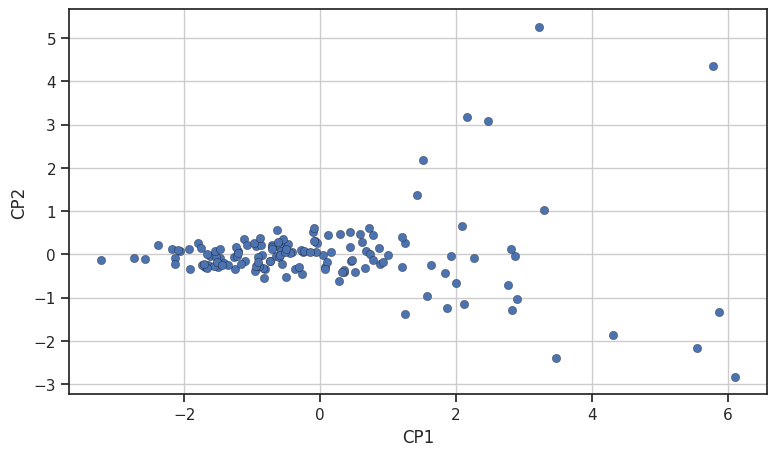

In [87]:
plt.figure(figsize=(9,5))
plt.scatter(resultado_pca[:, 0], resultado_pca[:, 1], edgecolors='black', linewidths=.2);
plt.xlabel('CP1')
plt.ylabel('CP2')
plt.grid();

### Efeito das variáveis em cada componente

O atributo 'components_' nos dá os autovetores que representam a direção de máxima variância dos dados. Ao verificar a correlação dos componentes com as variáveis originais podemos ver a influência que cada variável tem sobre os componentes.

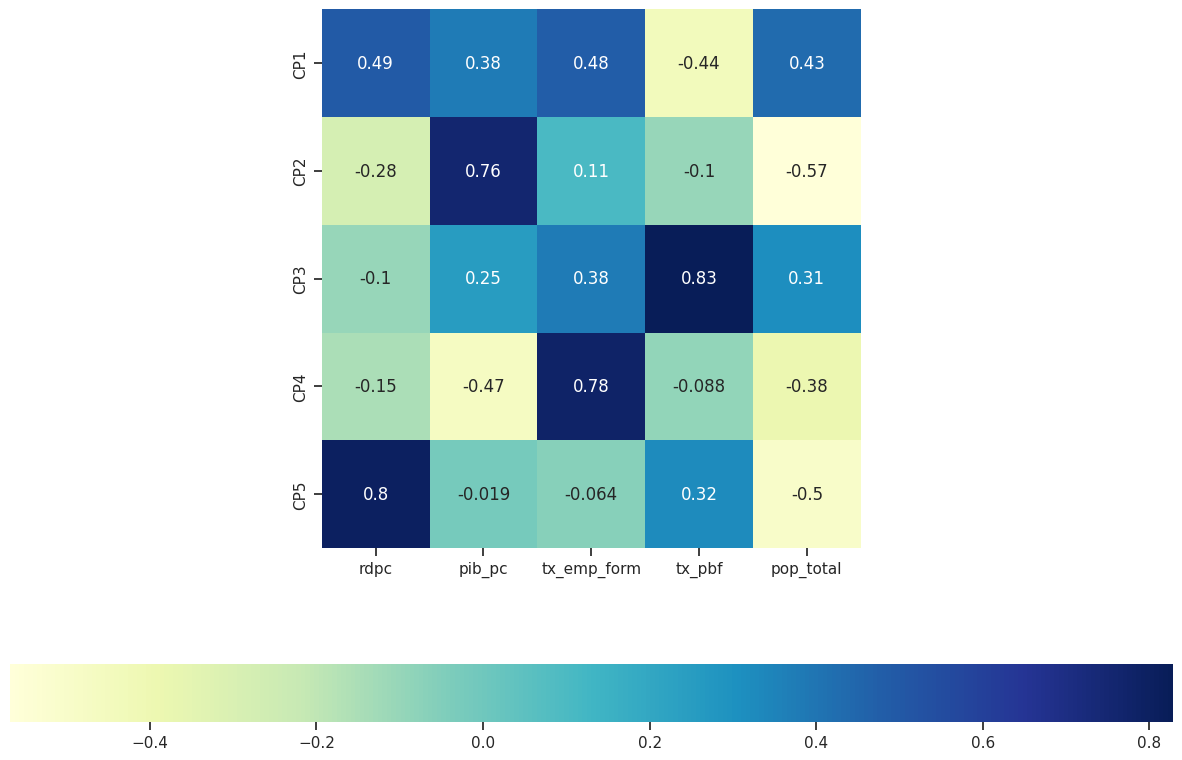

In [88]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(pca.components_,
                 annot=True,
                 cmap='YlGnBu',
                 yticklabels=[ "CP"+str(X) for X in range(1,pca.n_components_+1)],
                 xticklabels=list(X.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

### ACP *Biplot*

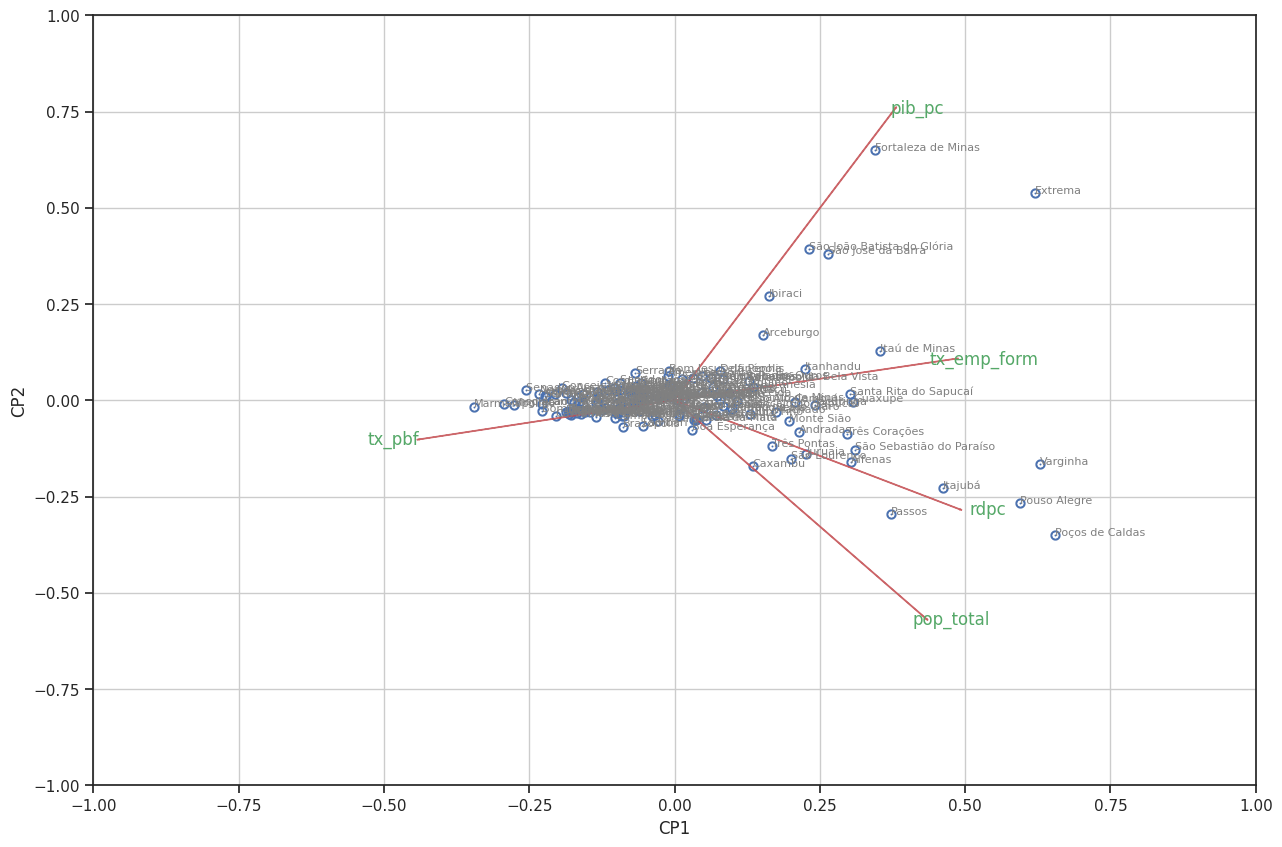

In [89]:
biplot_names(resultado_pca[:,0:2],np.transpose(pca.components_[0:2, :]),list(X.columns))

## Diagramas de dispersão com tamanhos das bolhas

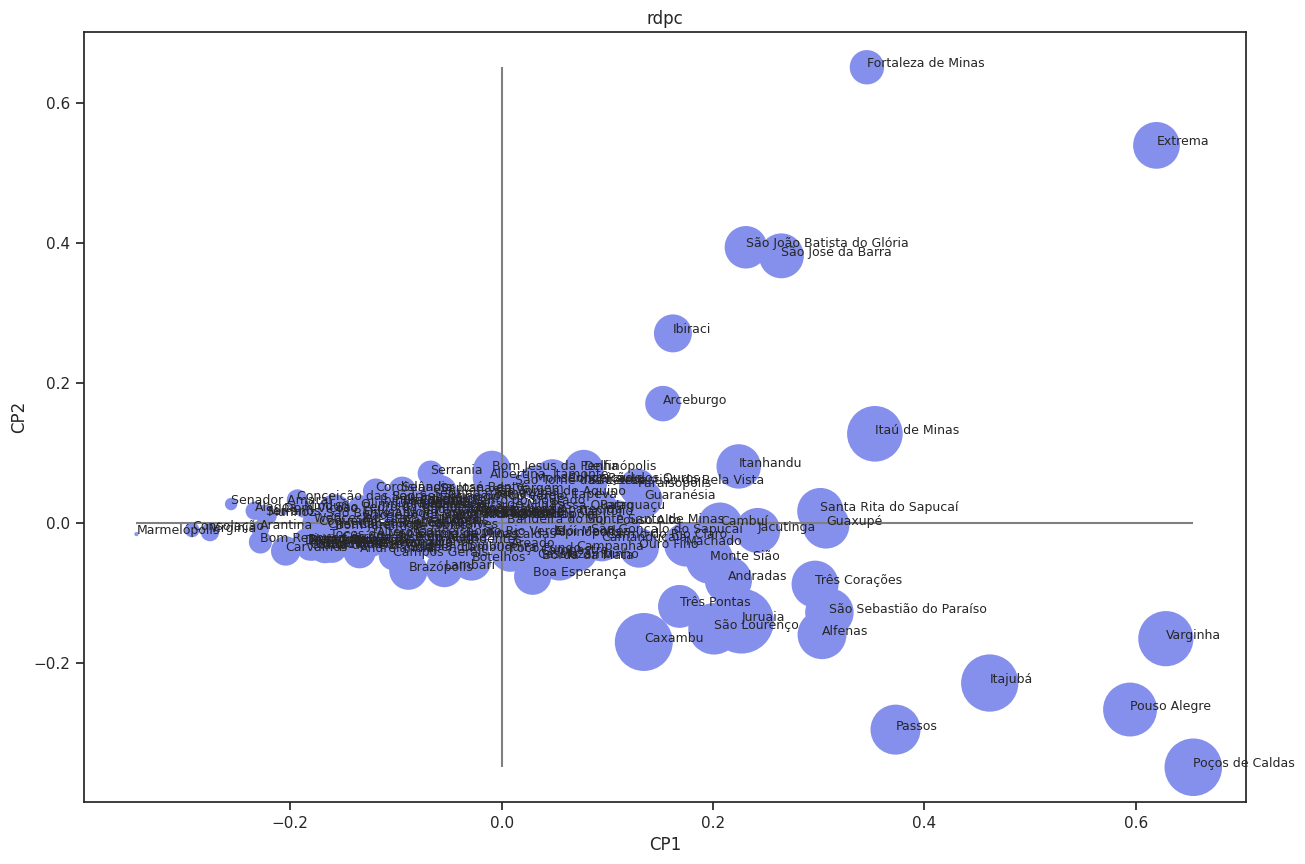

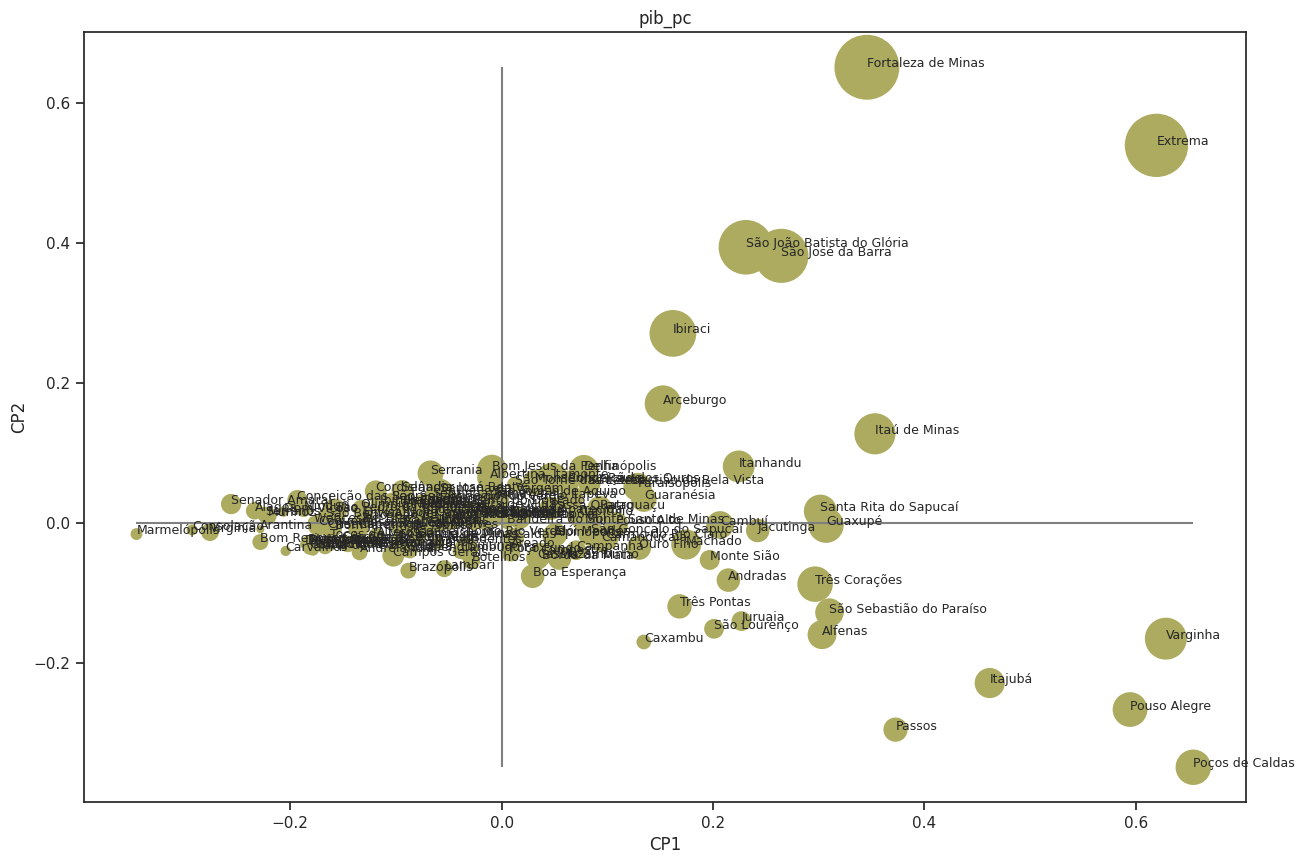

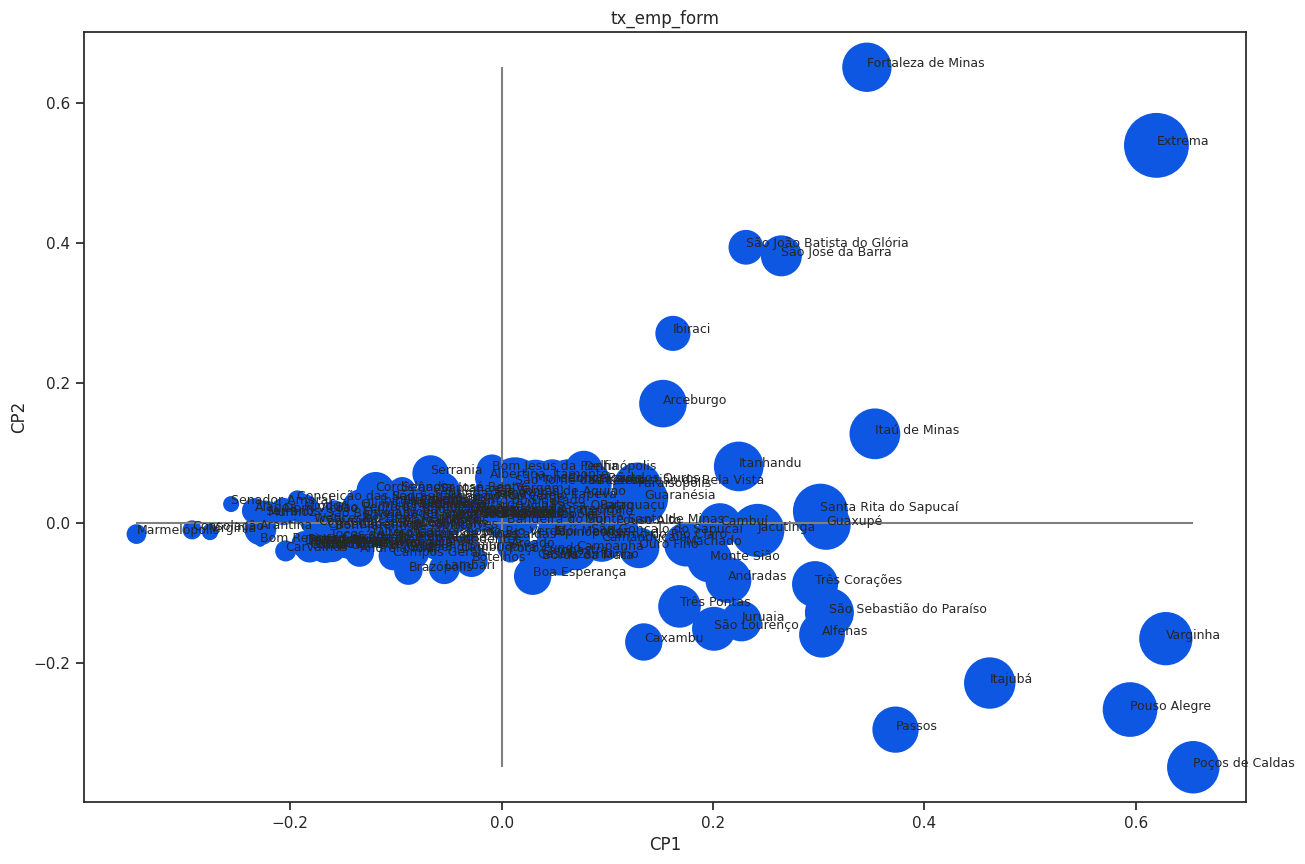

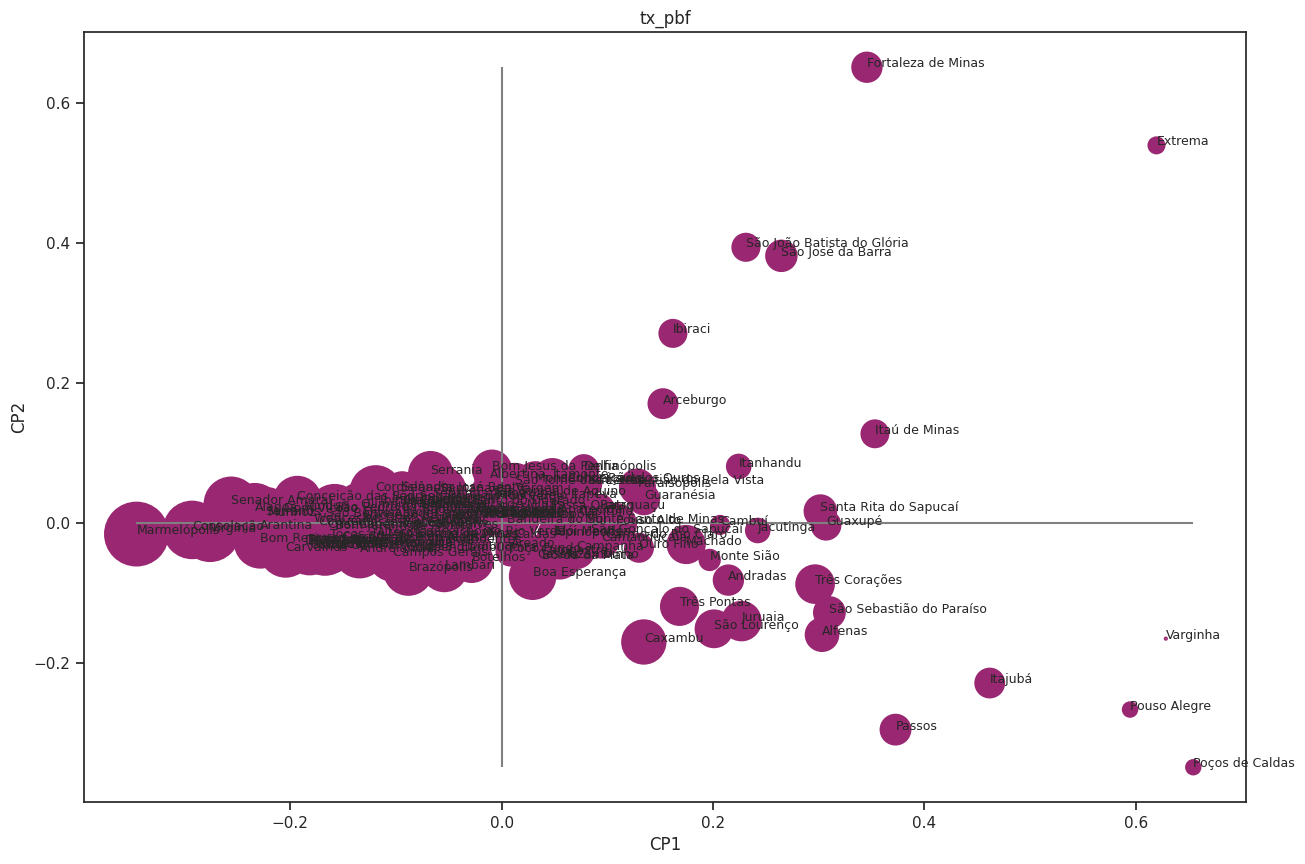

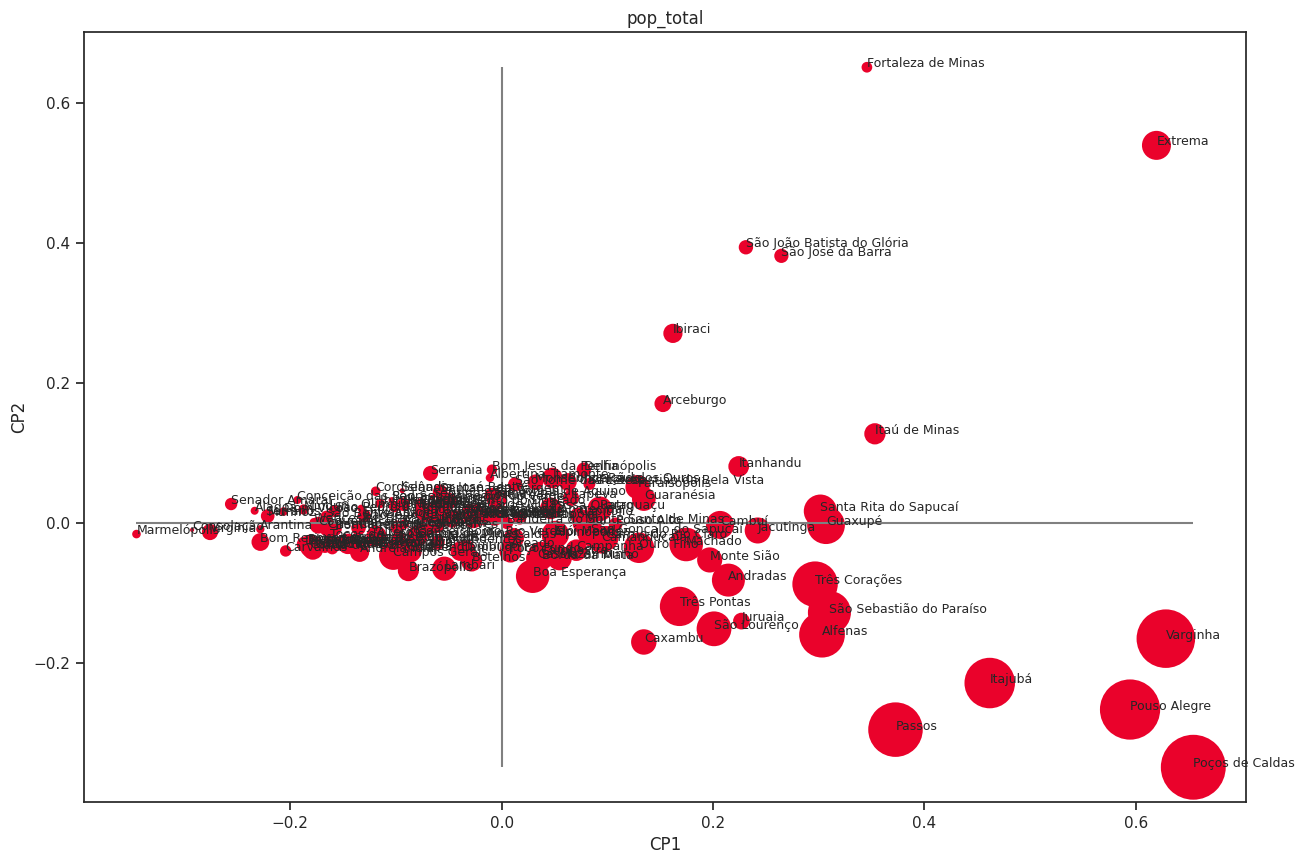

In [90]:
bubbles(dados, resultado)

In [91]:
# resultado.sort_values(by='cp1', ascending=True)

In [92]:
dados.query("index == ['Poços de Caldas', 'Varginha', 'Extrema', 'Fortaleza de Minas', 'São Tomé das Letras', 'Marmelópolis']")

rdpc   pib_pc  tx_emp_form  tx_pbf  pop_total
mun                                                                
Extrema             745.21 69063.46        60.20    2.10      28564
Fortaleza de Minas  562.53 72426.83        37.70    3.83       4098
Marmelópolis        367.73  7055.09        12.70   12.87       2968
Poços de Caldas     953.96 24079.16        41.70    1.96     152496
São Tomé das Letras 428.33  8559.06        44.00    6.24       6655
Varginha            904.57 32144.45        42.80    1.42     123120

In [93]:
dados.describe()

rdpc   pib_pc  tx_emp_form  tx_pbf  pop_total
count  146.00   146.00       146.00  146.00     146.00
mean   584.18 13405.99        23.28    6.07   16706.63
std    130.34  9686.16         9.02    2.24   23682.60
min    367.73  5666.74         8.90    1.42    1727.00
25%    496.13  8651.18        17.00    4.12    5220.50
50%    556.96 11028.65        21.60    5.70    9515.50
75%    642.56 13882.60        28.18    7.76   16837.00
max   1122.10 72426.83        60.20   12.87  152496.00

In [94]:
dados.query('index == ["Fortaleza de Minas", "Extrema"]')

rdpc   pib_pc  tx_emp_form  tx_pbf  pop_total
mun                                                               
Extrema            745.21 69063.46        60.20    2.10      28564
Fortaleza de Minas 562.53 72426.83        37.70    3.83       4098

In [95]:
dados.describe()

rdpc   pib_pc  tx_emp_form  tx_pbf  pop_total
count  146.00   146.00       146.00  146.00     146.00
mean   584.18 13405.99        23.28    6.07   16706.63
std    130.34  9686.16         9.02    2.24   23682.60
min    367.73  5666.74         8.90    1.42    1727.00
25%    496.13  8651.18        17.00    4.12    5220.50
50%    556.96 11028.65        21.60    5.70    9515.50
75%    642.56 13882.60        28.18    7.76   16837.00
max   1122.10 72426.83        60.20   12.87  152496.00

In [96]:
# resultado.sort_values(by='cp1', ascending=True)

In [97]:
# mg.query("index == 'Santa Cruz de Salinas'")

In [98]:
# escolher
# escolhidos = dados.query('index == ["Belo Horizonte", "Nova Lima", "Jeceaba", "Tapira", "Confins"]')

In [99]:
# escolhidos

# Outras opções:

- escolher mais ou menos variáveis e verificar como fica a análise
- retirar alguns municípios e ver como ficaria a análise
- escolher outras mesorregiões

In [100]:
# se quiséssemos tirar alguma cidade para ver como ficaria
dados = dados.query('index != ["Belo Horizonte", "Nova Lima"]')

E depois efetuar a análise novamente.